In [1]:
#cloning repo
!git clone https://github.com/ewatson2/EEL6812_DeepFool_Project

Cloning into 'EEL6812_DeepFool_Project'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 96 (delta 2), reused 1 (delta 1), pack-reused 93
Receiving objects: 100% (96/96), 33.99 MiB | 26.67 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [2]:
#заходим в директорию
%cd EEL6812_DeepFool_Project

/content/EEL6812_DeepFool_Project


In [3]:
#импорт нужных библиотек
import numpy as np
import json, torch
import os
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from torchvision.transforms import transforms
from models.project_models import FC_500_150, LeNet_CIFAR, LeNet_MNIST, Net
from utils.project_utils import get_clip_bounds, evaluate_attack, display_attack

In [4]:
#значение rand_seed согласно варианту = Исаев А.М. - 43
rand_seed = 43
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

# в качестсве устройства используем видеокарту
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [5]:
#задаем значения для предобработки датасета MNIST
mnist_mean = 0.5
mnist_std = 0.5
mnist_dim = 28

mnist_min, mnist_max = get_clip_bounds(mnist_mean,
                                       mnist_std,
                                       mnist_dim)
mnist_min = mnist_min.to(device)
mnist_max = mnist_max.to(device)

mnist_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mnist_mean,
        std=mnist_std)])

mnist_tf_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mnist_mean,
        std=mnist_std)])

mnist_tf_inv = transforms.Compose([
    transforms.Normalize(
        mean=0.0,
        std=np.divide(1.0, mnist_std)),
    transforms.Normalize(
        mean=np.multiply(-1.0, mnist_std),
        std=1.0)])

mnist_temp = datasets.MNIST(root='datasets/mnist', train=True,
                            download=True, transform=mnist_tf_train)
mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])

mnist_test = datasets.MNIST(root='datasets/mnist', train=False,
                            download=True, transform=mnist_tf)

100%|██████████| 9912422/9912422 [00:00<00:00, 162353752.31it/s]

Extracting datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 108934976.46it/s]


Extracting datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41660741.52it/s]

Extracting datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5916313.28it/s]


Extracting datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw



In [6]:
#также задаем значения и предобрабатываем для следующего датасета cifar-10
cifar_mean = [0.491, 0.482, 0.447]
cifar_std = [0.202, 0.199, 0.201]
cifar_dim = 32

cifar_min, cifar_max = get_clip_bounds(cifar_mean,
                                       cifar_std,
                                       cifar_dim)
cifar_min = cifar_min.to(device)
cifar_max = cifar_max.to(device)

cifar_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=cifar_mean,
        std=cifar_std)])

cifar_tf_train = transforms.Compose([
    transforms.RandomCrop(
        size=cifar_dim,
        padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=cifar_mean,
        std=cifar_std)])

cifar_tf_inv = transforms.Compose([
    transforms.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=np.divide(1.0, cifar_std)),
    transforms.Normalize(
        mean=np.multiply(-1.0, cifar_mean),
        std=[1.0, 1.0, 1.0])])

cifar_temp = datasets.CIFAR10(root='datasets/cifar-10', train=True,
                              download=True, transform=cifar_tf_train)
cifar_train, cifar_val = random_split(cifar_temp, [40000, 10000])

cifar_test = datasets.CIFAR10(root='datasets/cifar-10', train=False,
                              download=True, transform=cifar_tf)

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170498071/170498071 [00:05<00:00, 31022041.03it/s]


Extracting datasets/cifar-10/cifar-10-python.tar.gz to datasets/cifar-10
Files already downloaded and verified


In [7]:
# Настройка и загрузка Dataloader
batch_size = 64
workers = 4

mnist_loader_train = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=workers)
mnist_loader_val = DataLoader(mnist_val, batch_size=batch_size, shuffle=False, num_workers=workers)
mnist_loader_test = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=workers)

cifar_loader_train = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=workers)
cifar_loader_val = DataLoader(cifar_val, batch_size=batch_size, shuffle=False, num_workers=workers)
cifar_loader_test = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
# Загружаем и оцениваем стойкость модели LeNet к FGSM и DeepFool атакам
fgsm_eps = 0.6

model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth', map_location=torch.device('cpu')))

evaluate_attack('mnist_lenet_fgsm.csv', 'results', device, model, mnist_loader_test, mnist_min, mnist_max, fgsm_eps, is_fgsm=True)

print('')

batch = 64
num_classes = 10
overshoot = 0.02
max_iter = 50
deep_arg = [batch, num_classes, overshoot, max_iter]

evaluate_attack('mnist_lenet_deepfool.csv', 'results', device, model, mnist_loader_test, mnist_min, mnist_max, deep_arg, is_fgsm=False)

if device.type == 'cuda':
  torch.cuda.empty_cache()

FGSM Test Error : 87.89%
FGSM Robustness : 4.58e-01
FGSM Time (All Images) : 0.29 s
FGSM Time (Per Image) : 28.86 us

DeepFool Test Error : 98.74%
DeepFool Robustness : 9.64e-02
DeepFool Time (All Images) : 193.32 s
DeepFool Time (Per Image) : 19.33 ms


In [9]:
# Загружаем и оцениваем стойкость модели FC к FGSM и DeepFool атакам
fgsm_eps = 0.2

model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth', map_location=torch.device('cpu')))

evaluate_attack('mnist_fc_fgsm.csv', 'results', device, model, mnist_loader_test, mnist_min, mnist_max, fgsm_eps, is_fgsm=True)

print('')

batch = 64
num_classes = 10
overshoot = 0.02
max_iter = 50
deep_arg = [batch, num_classes, overshoot, max_iter]

evaluate_attack('mnist_fc_deepfool.csv', 'results', device, model, mnist_loader_test, mnist_min, mnist_max, deep_arg, is_fgsm=False)

if device.type == 'cuda':
  torch.cuda.empty_cache()

FGSM Test Error : 87.08%
FGSM Robustness : 1.56e-01
FGSM Time (All Images) : 0.15 s
FGSM Time (Per Image) : 14.99 us

DeepFool Test Error : 97.92%
DeepFool Robustness : 6.78e-02
DeepFool Time (All Images) : 141.81 s
DeepFool Time (Per Image) : 14.18 ms


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


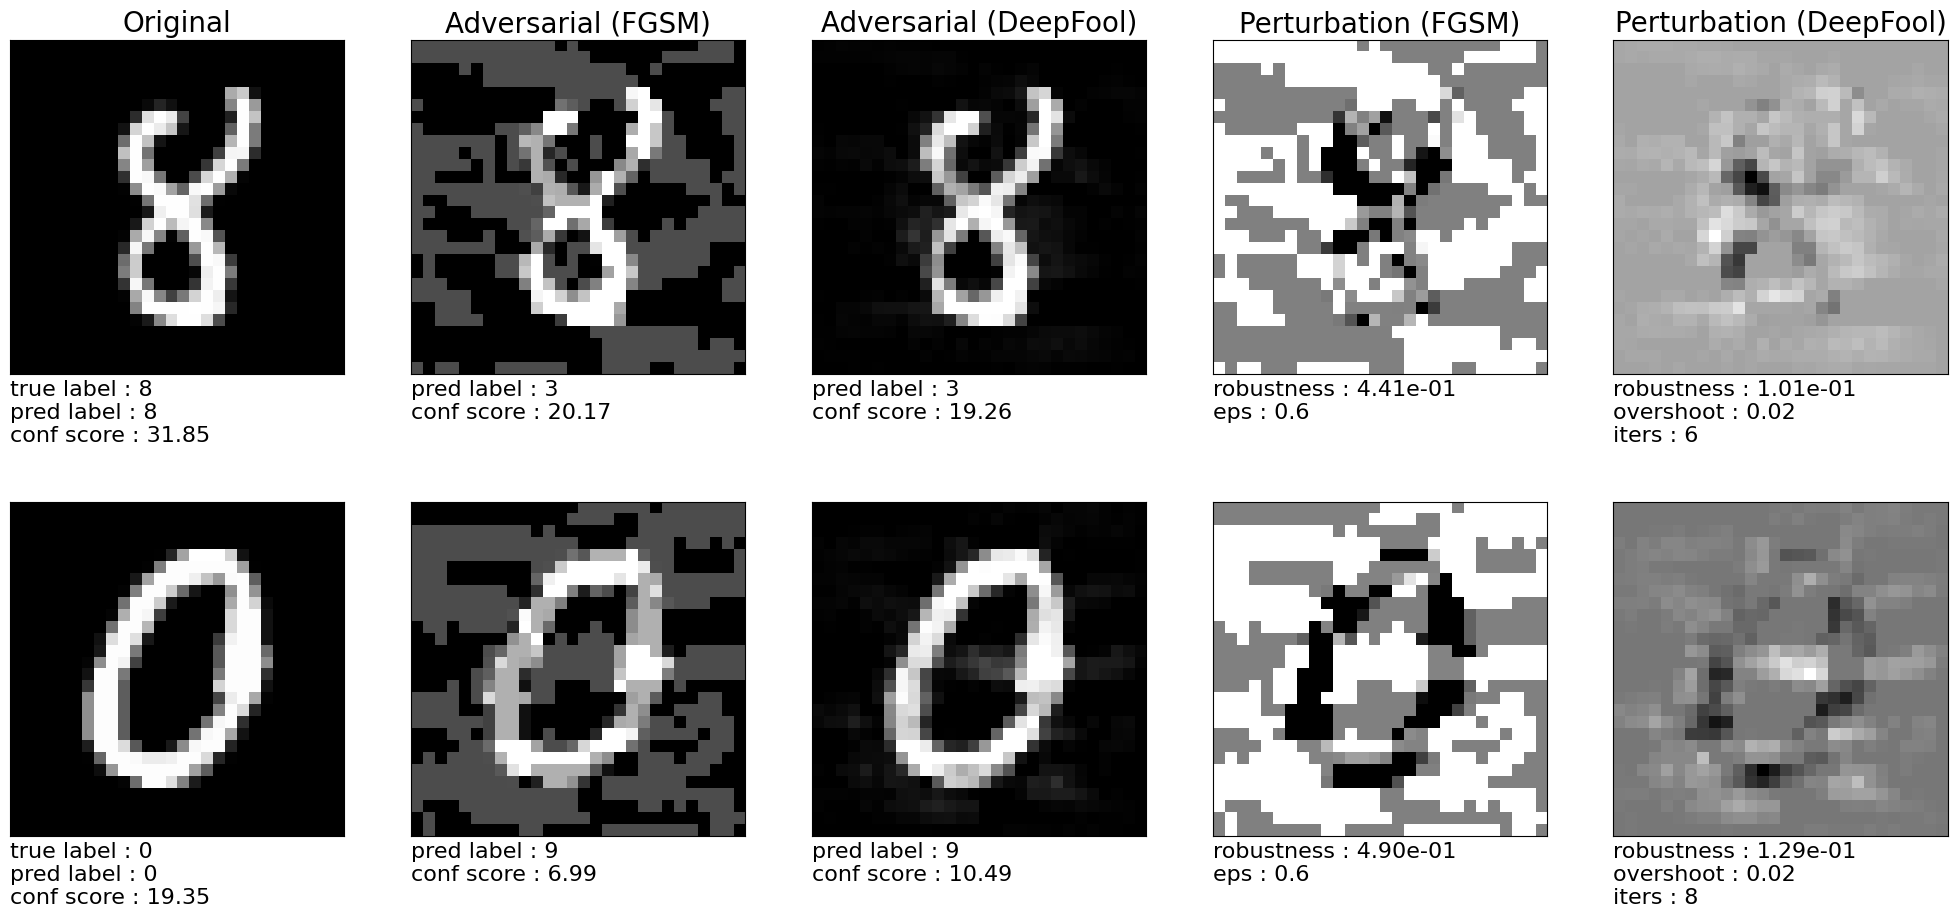

In [10]:
fgsm_eps = 0.6
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth', map_location=device))

display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_arg, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda': torch.cuda.empty_cache()

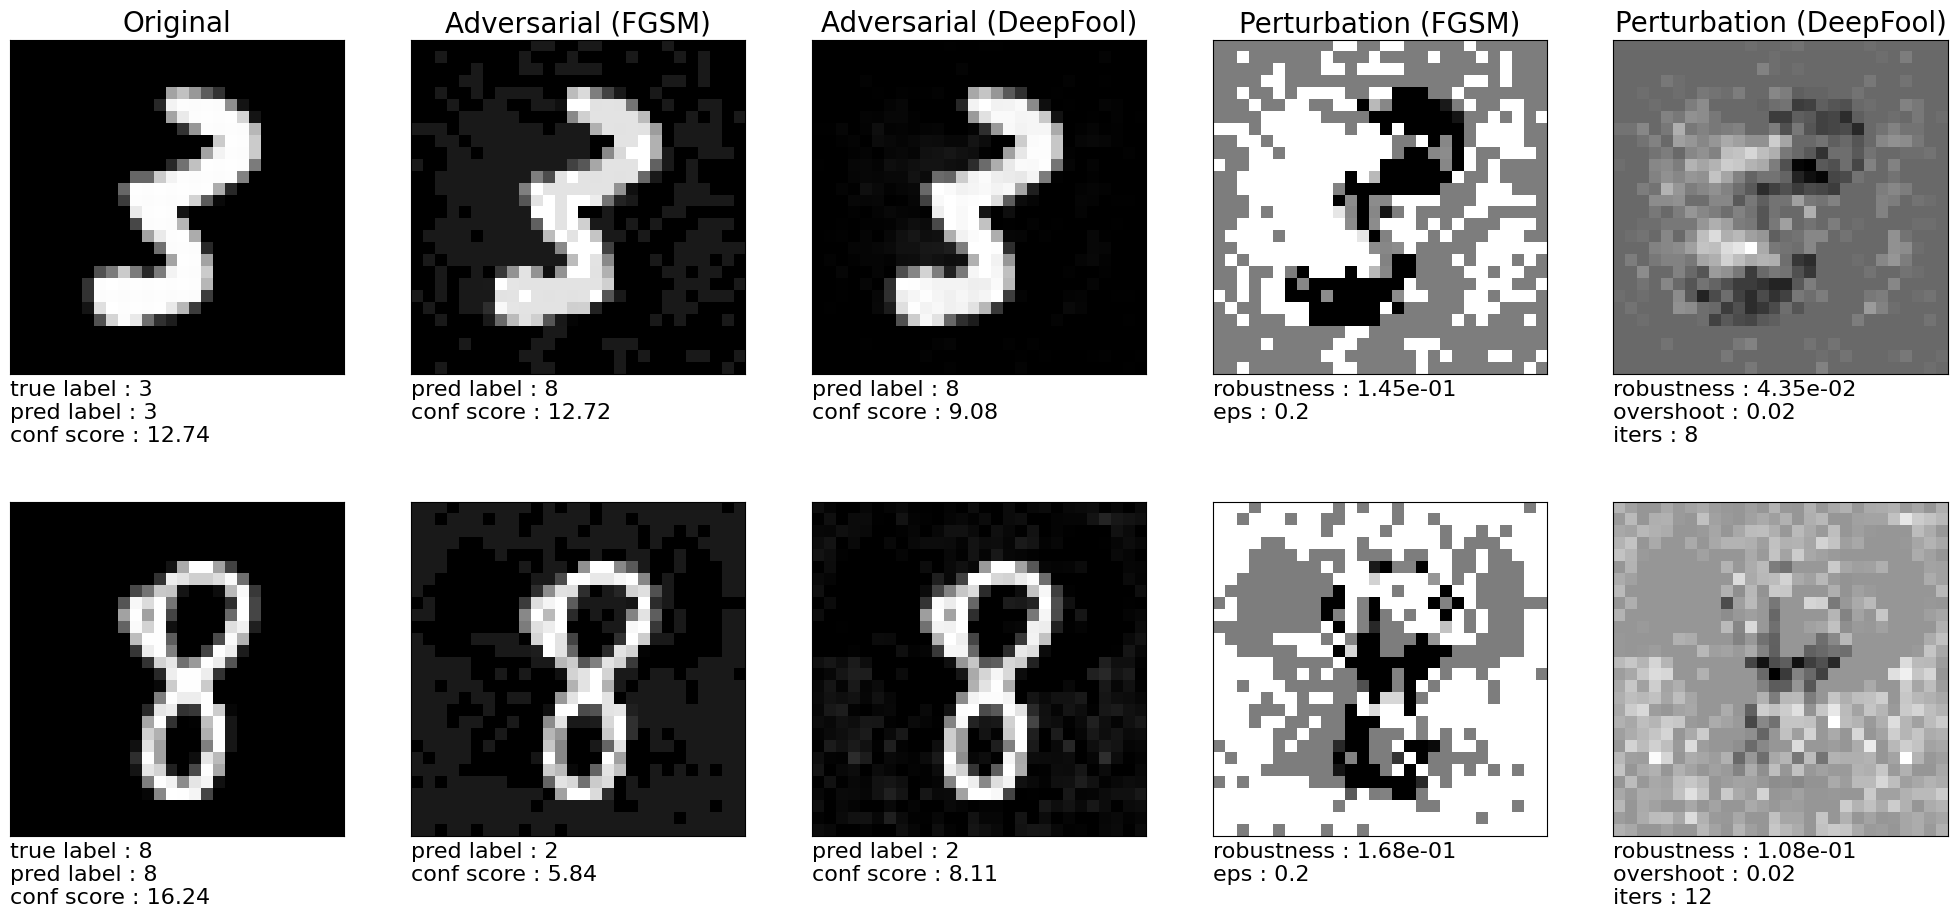

In [11]:
fgsm_eps = 0.2
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth', map_location=device))

display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_arg, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda': torch.cuda.empty_cache()


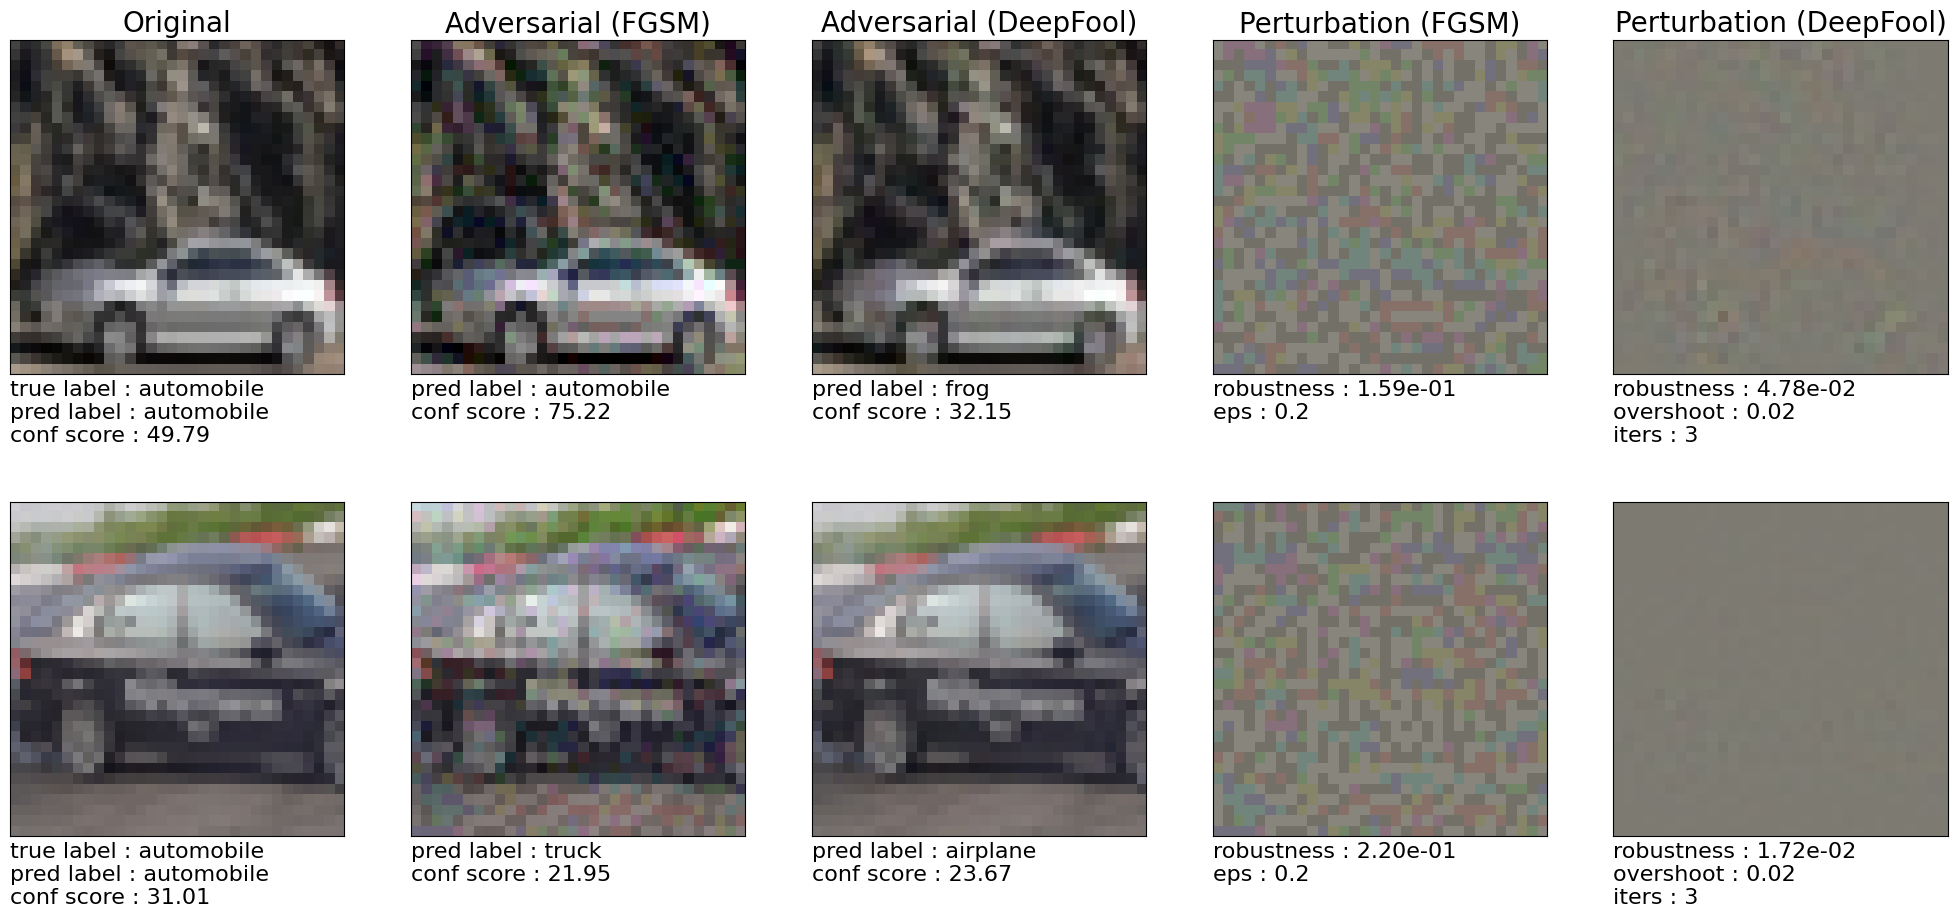

In [14]:
#Network-in-Network
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_arg, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)

if device.type == 'cuda': torch.cuda.empty_cache()

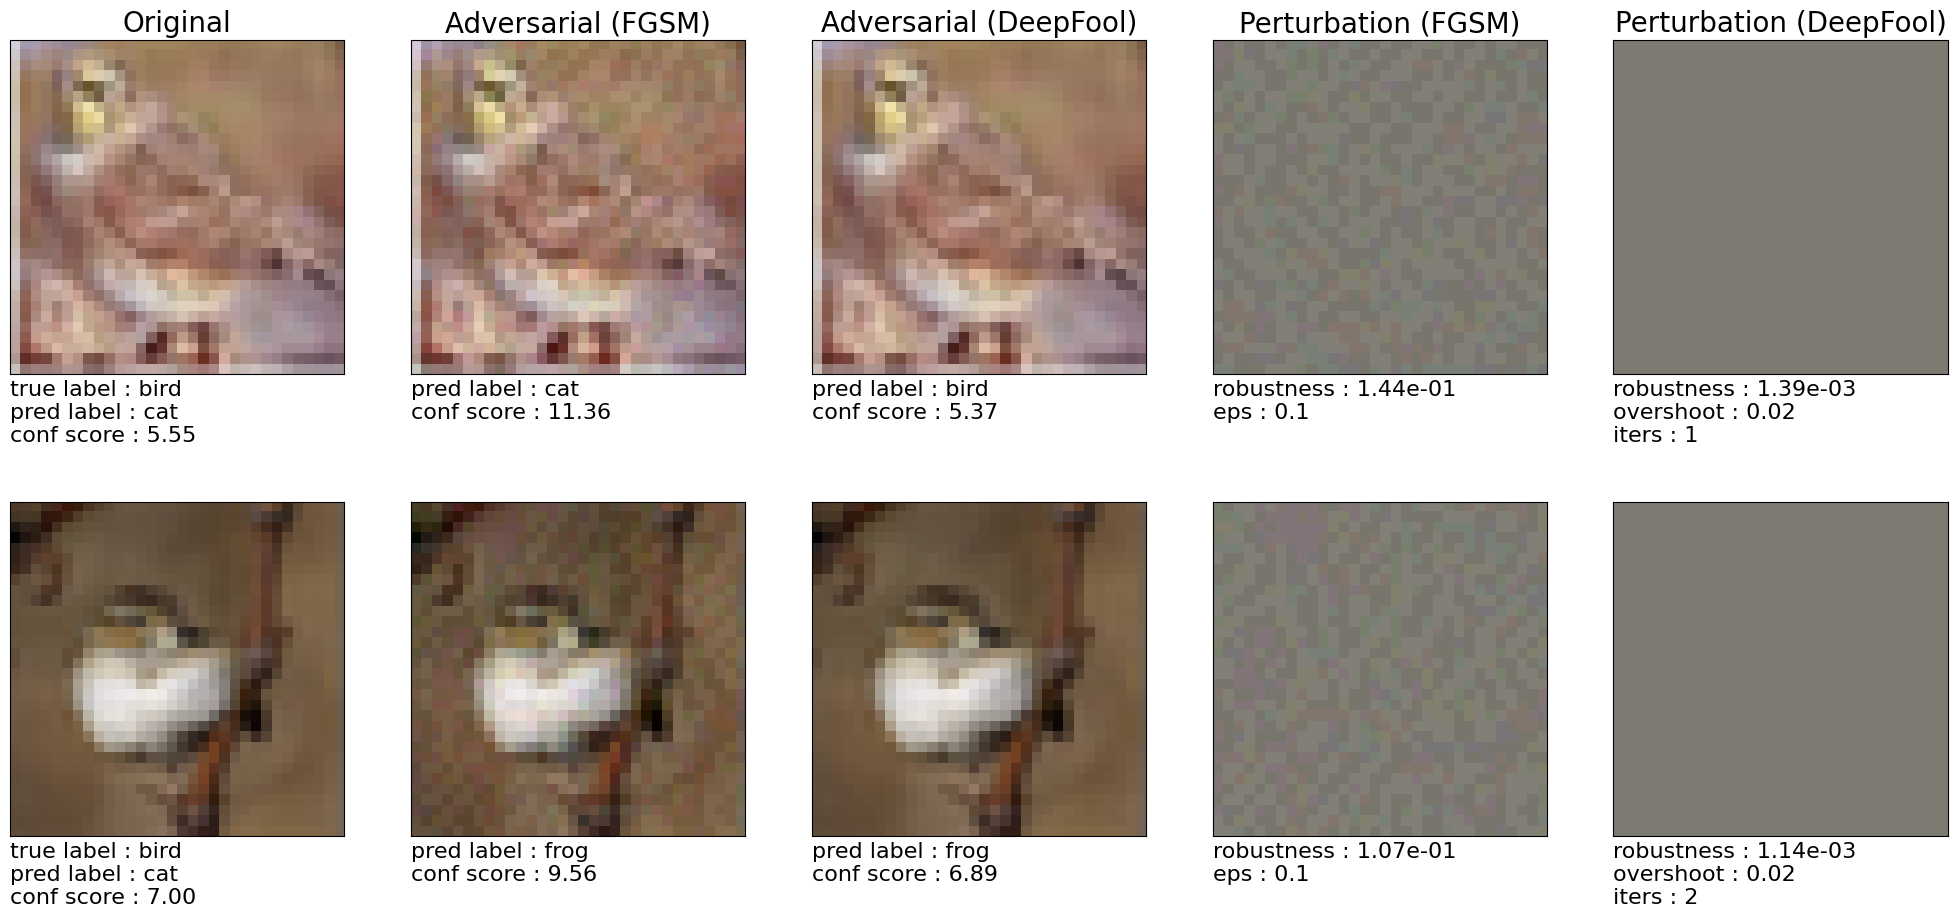

In [15]:
#LeNet CIFAR-10
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_arg, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)

if device.type == 'cuda': torch.cuda.empty_cache()

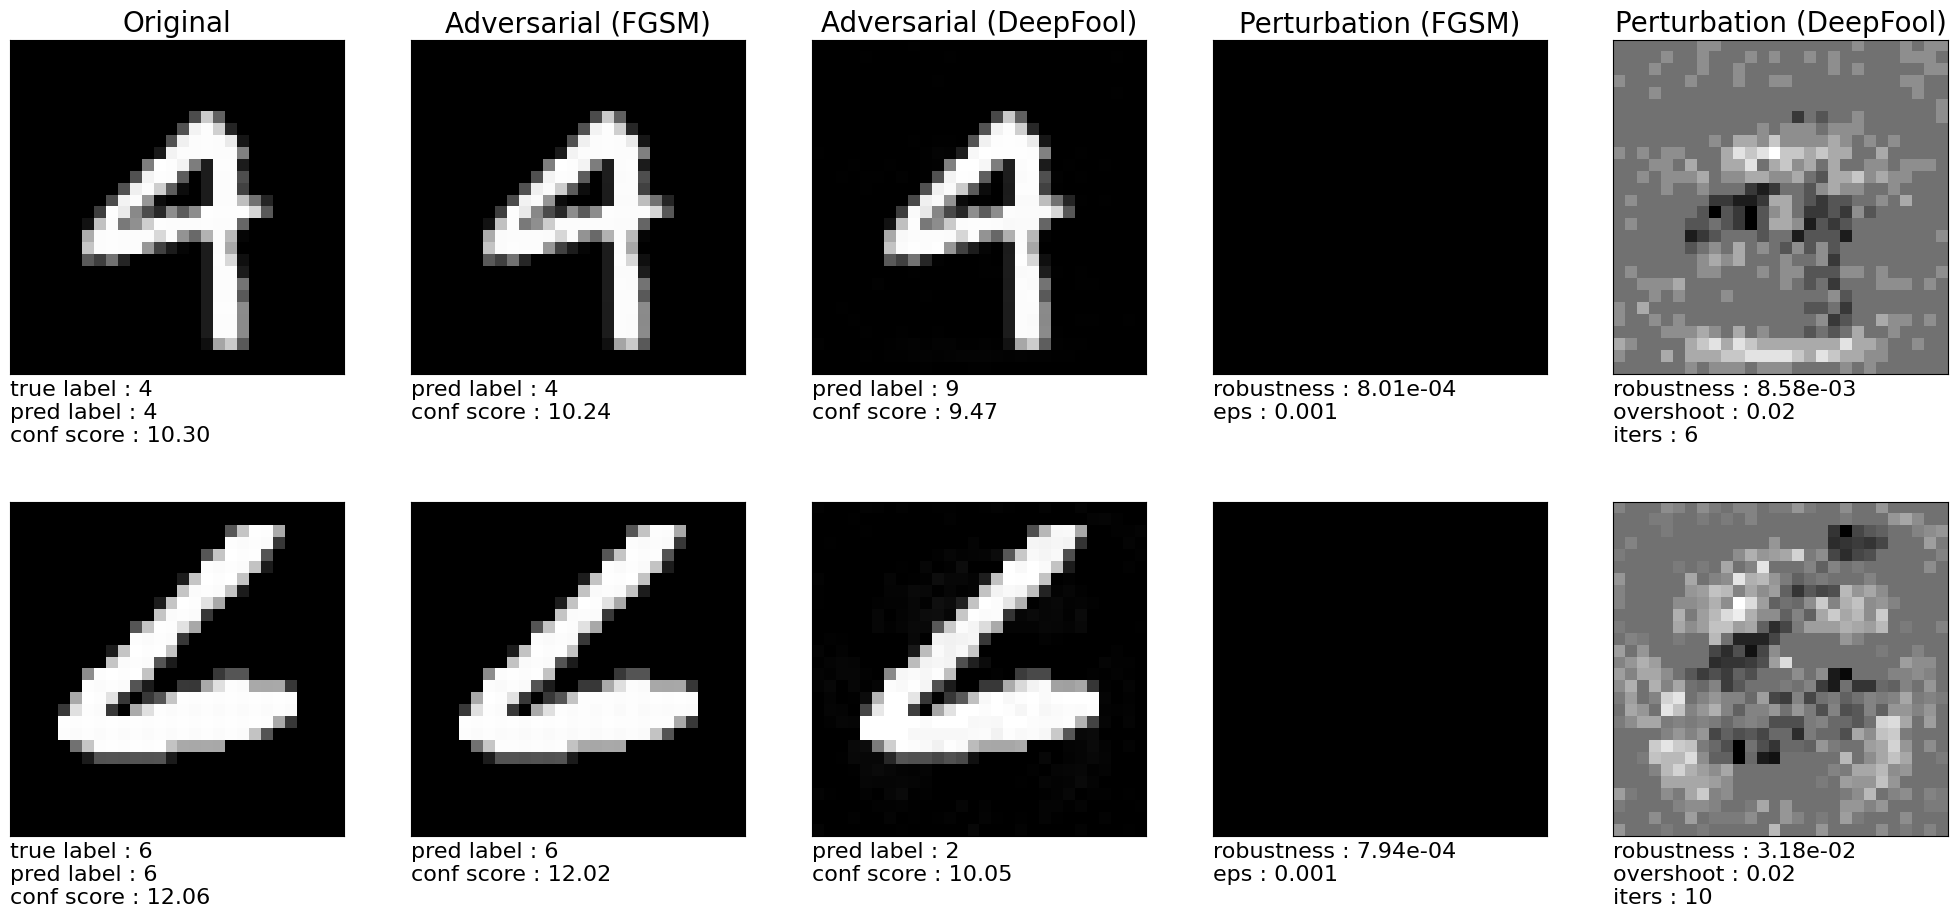

In [16]:
# отличия для fgsm_eps=(0.001, 0.02, 0.5, 0.9, 10) и выявить закономерность/обнаружить отсутсвие влияние параметра eps для сетей FC LeNet на датасете MNIST, NiN LeNEt на датасете CIFAR).

fgsm_eps = 0.001
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_arg, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda': torch.cuda.empty_cache()

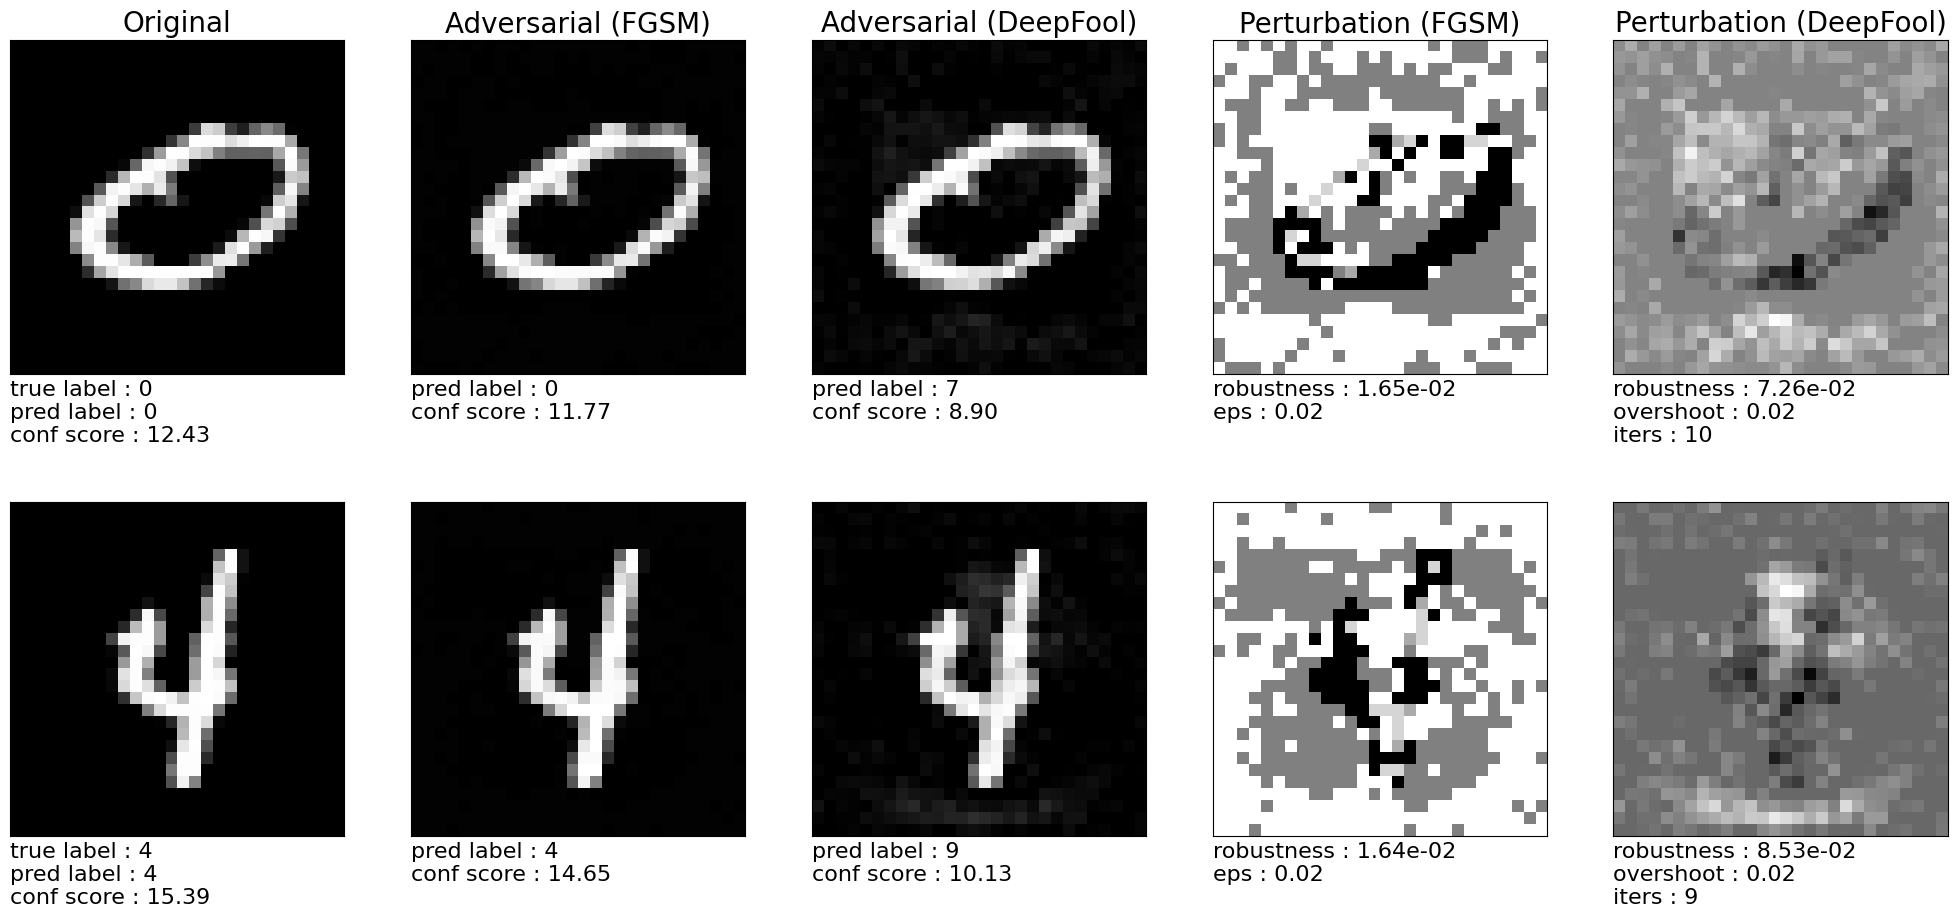

In [12]:
#0.02
fgsm_eps = 0.02
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_arg, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda': torch.cuda.empty_cache()

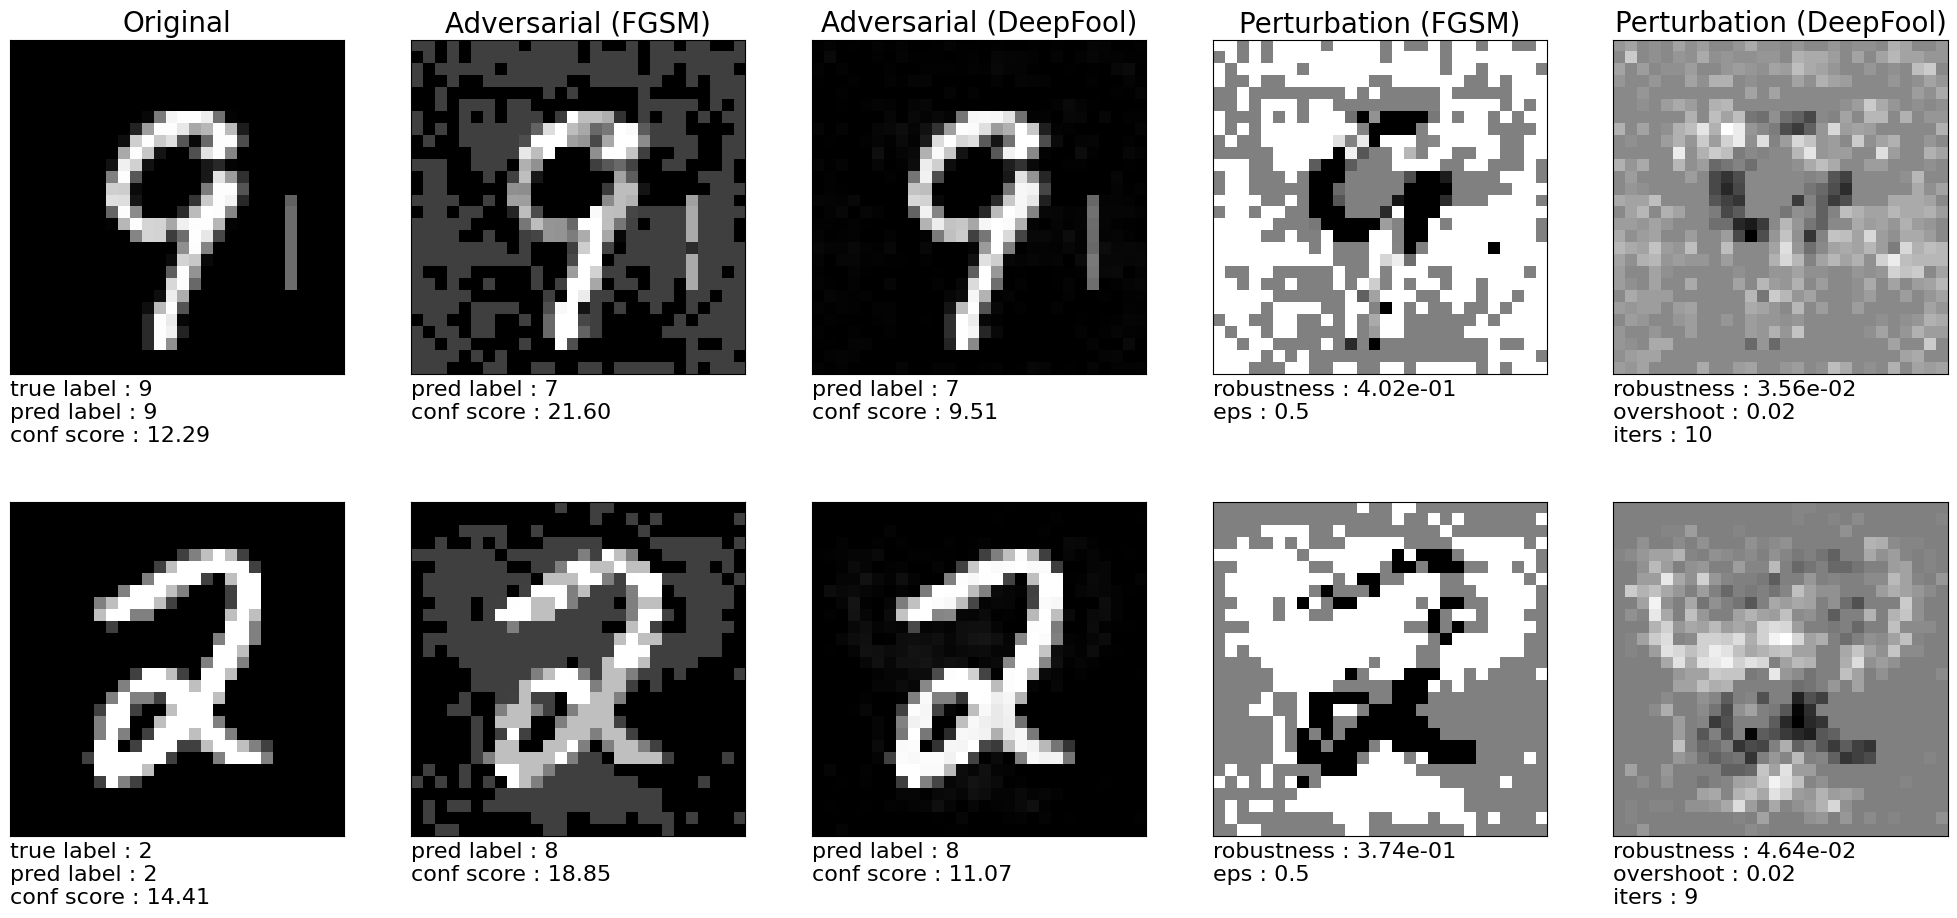

In [18]:
#0.5
fgsm_eps = 0.5
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_arg, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda': torch.cuda.empty_cache()

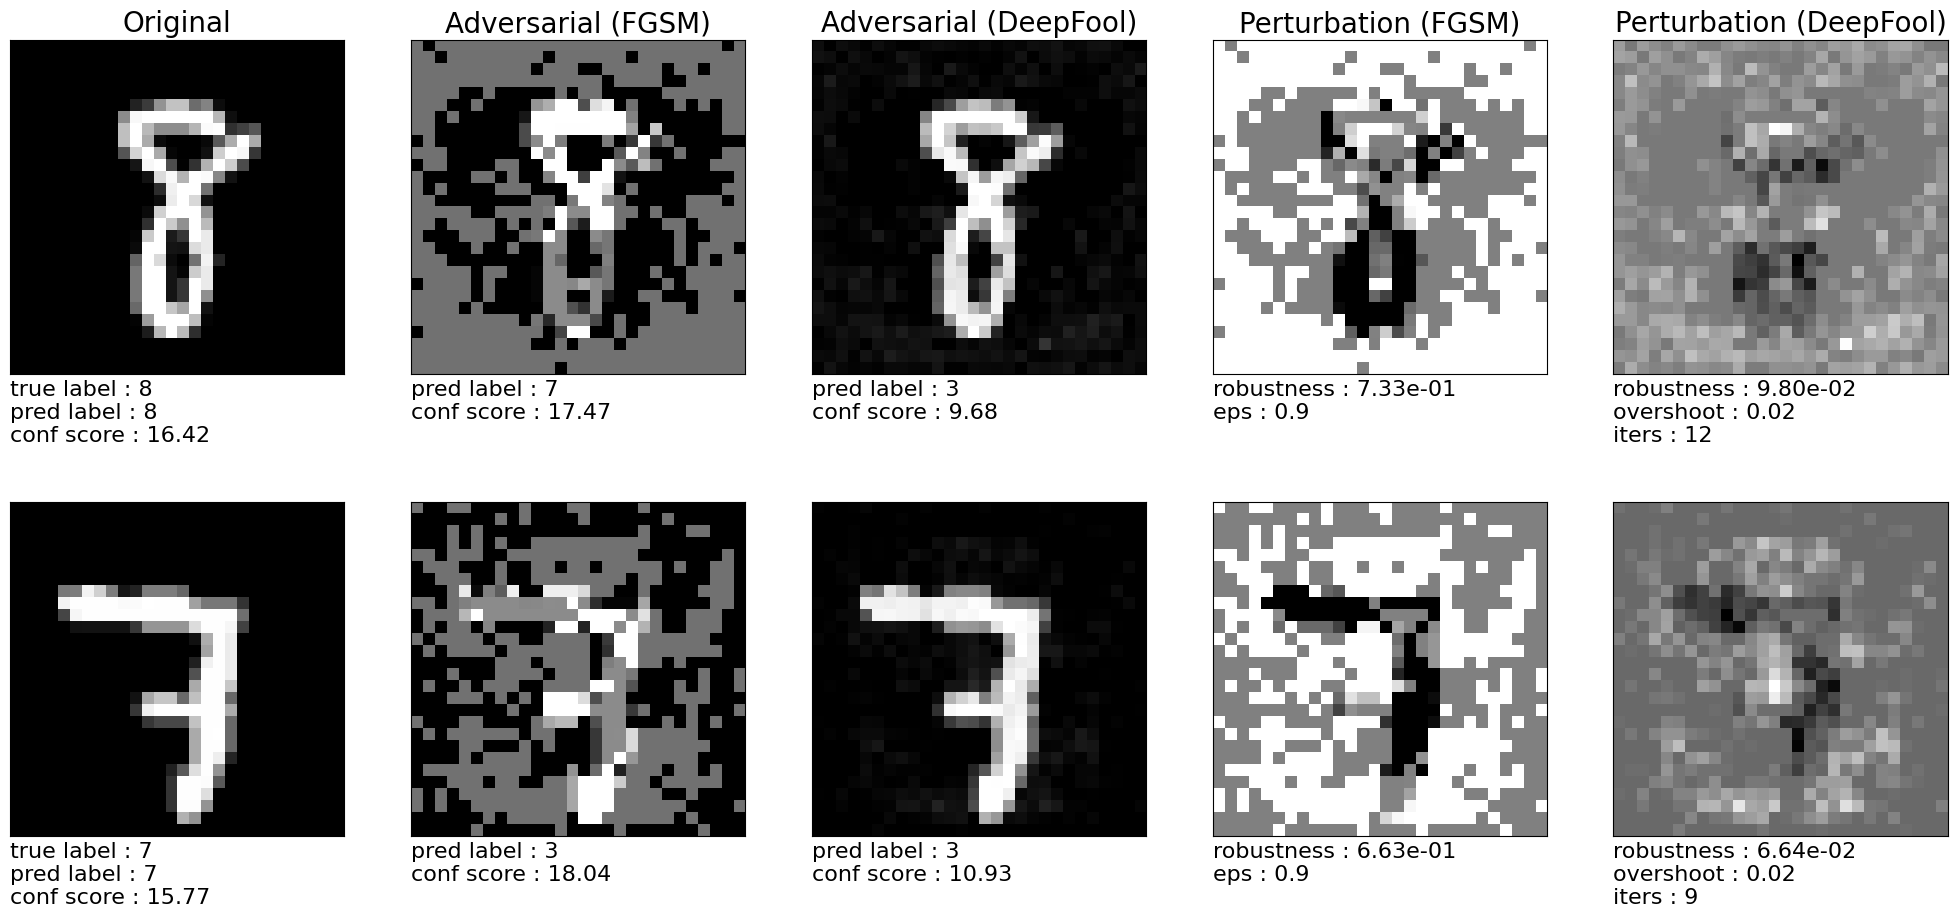

In [19]:
#0.9
fgsm_eps = 0.9
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_arg, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda': torch.cuda.empty_cache()

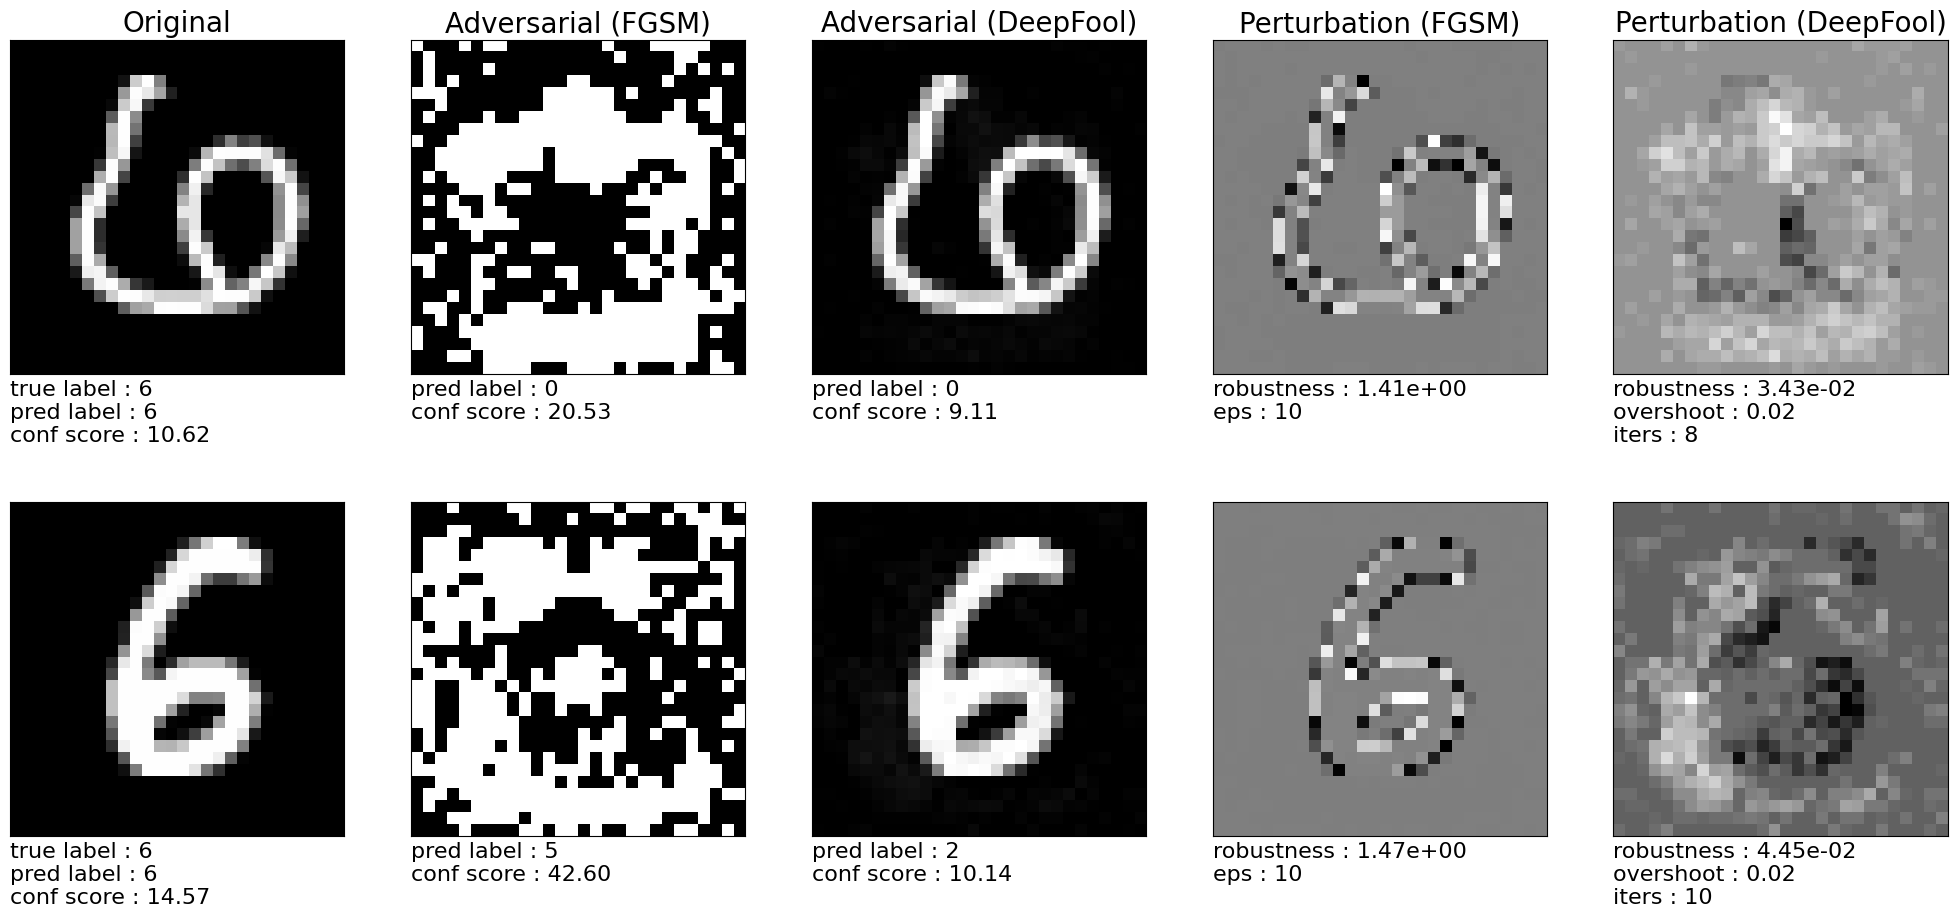

In [20]:
#10
fgsm_eps = 10
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_arg, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda': torch.cuda.empty_cache()

оценка LeNet на MNIST

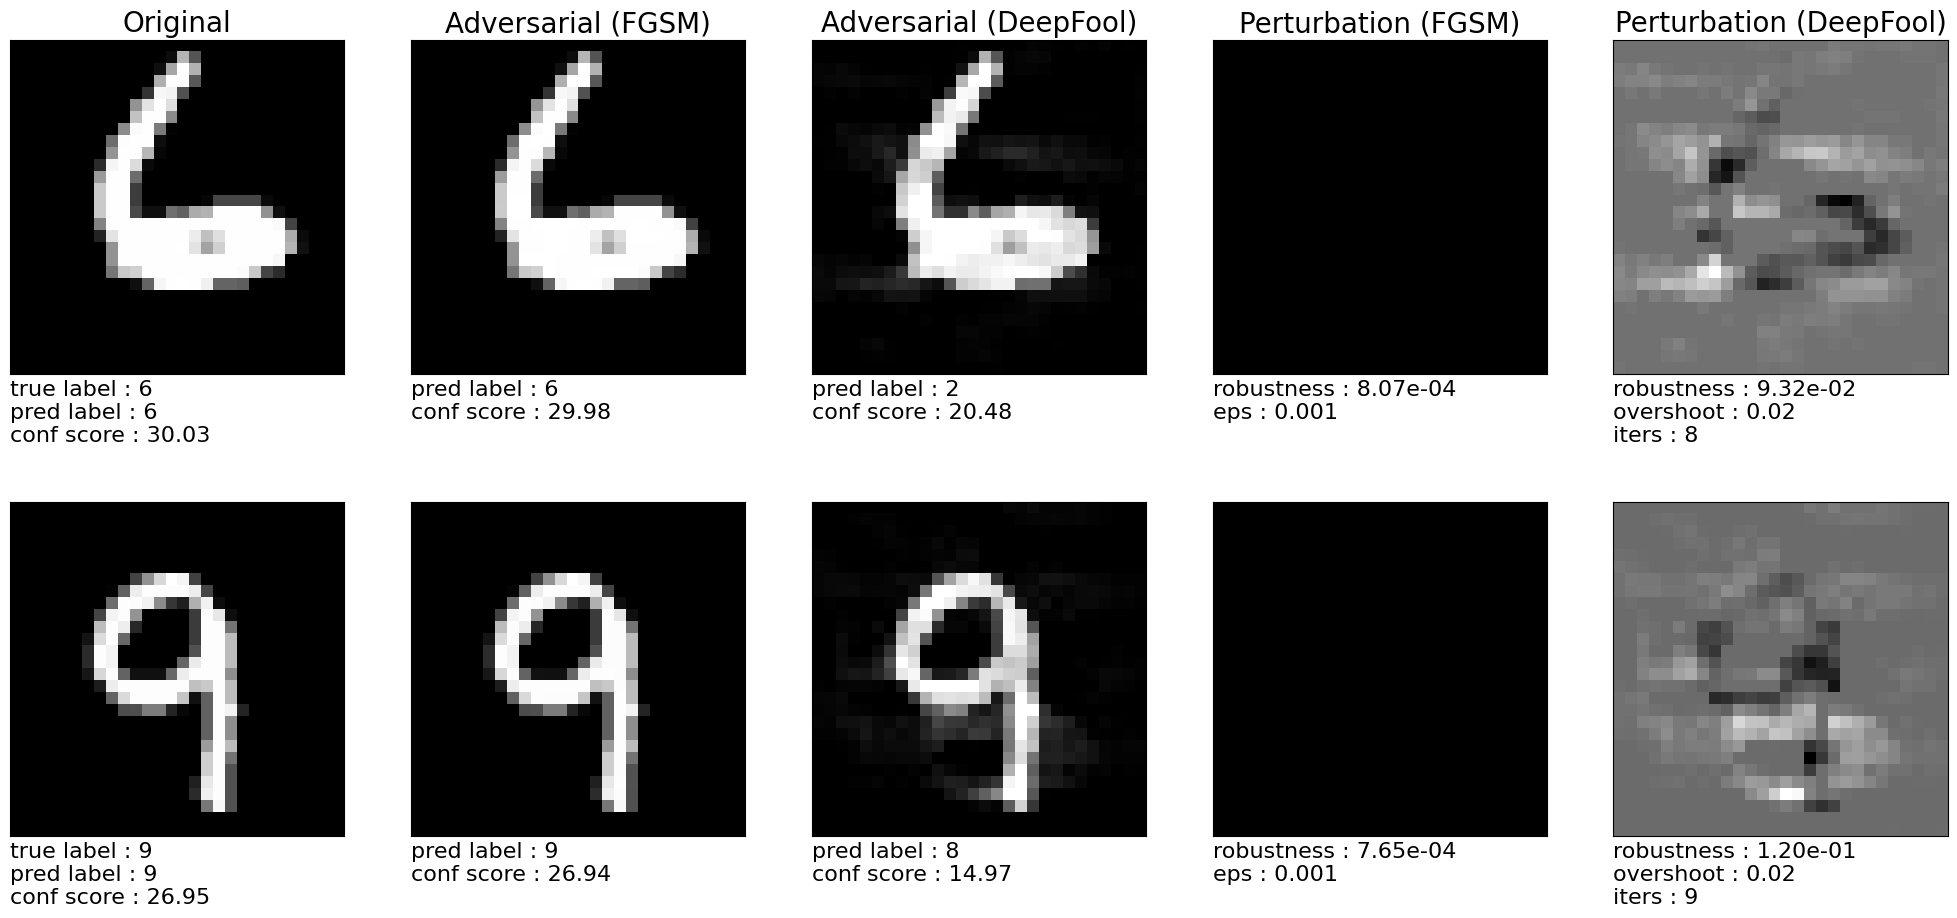

In [21]:
fgsm_eps = 0.001
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_arg, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda': torch.cuda.empty_cache()

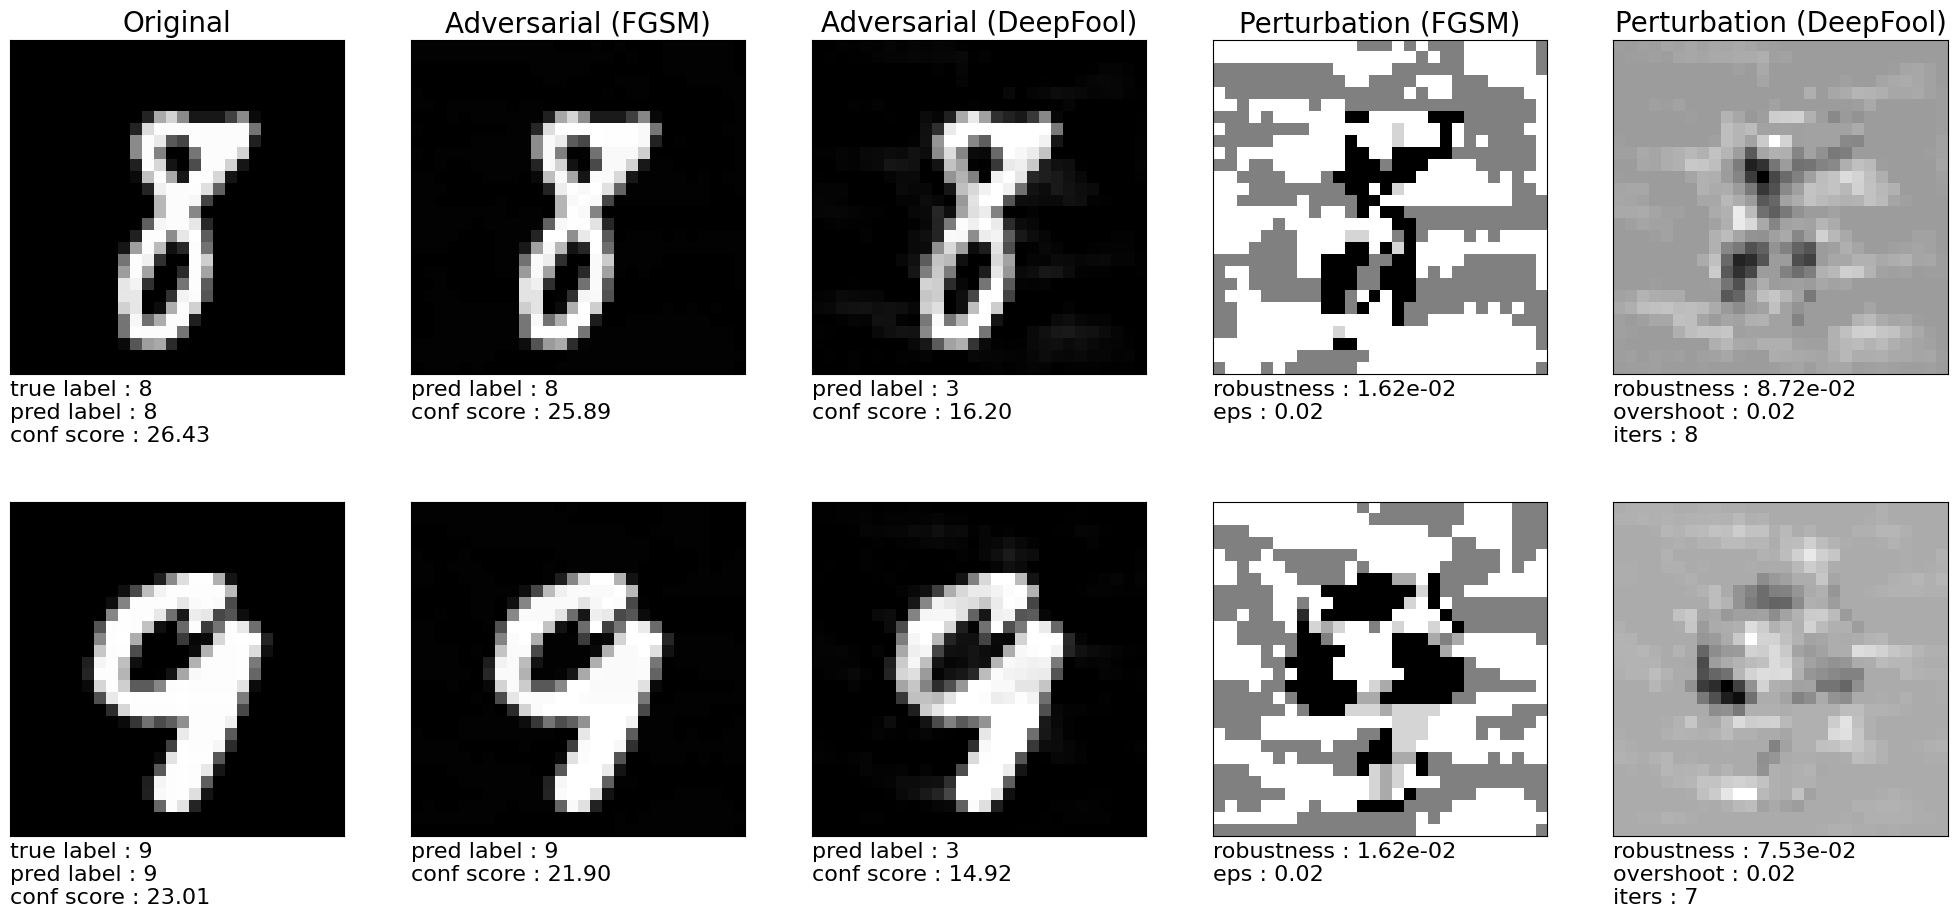

In [22]:
fgsm_eps = 0.02
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_arg, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda': torch.cuda.empty_cache()

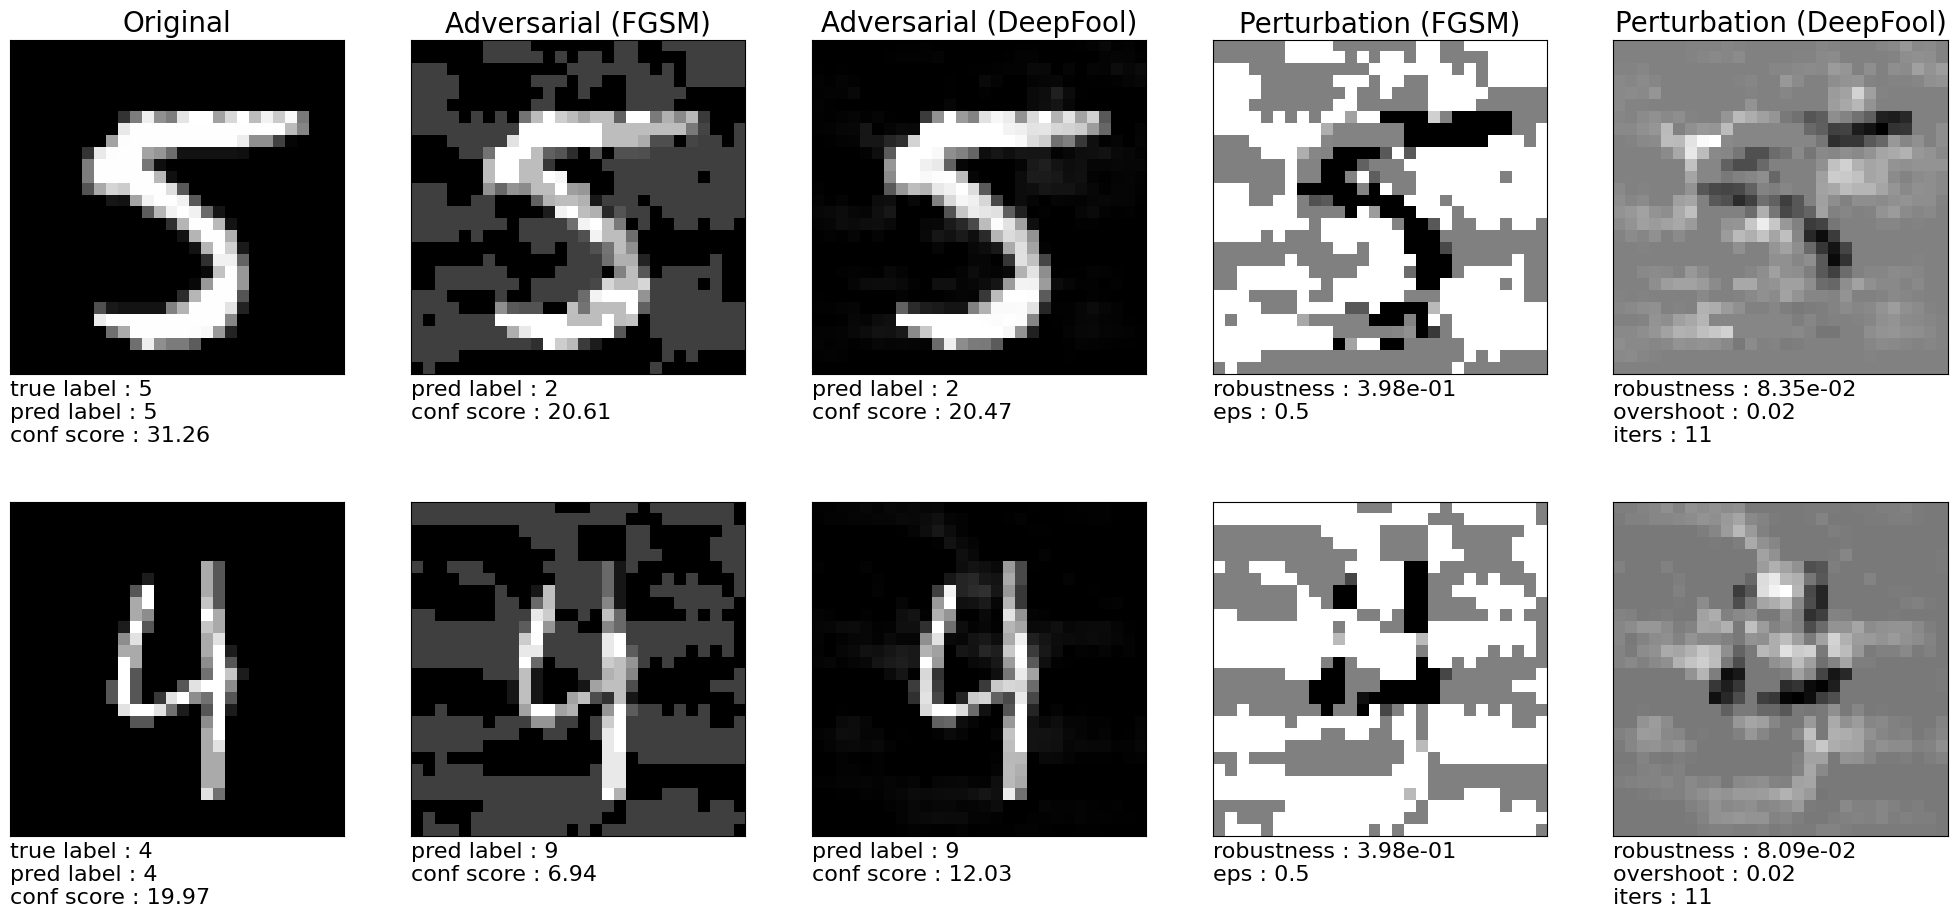

In [23]:
fgsm_eps = 0.5
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_arg, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda': torch.cuda.empty_cache()

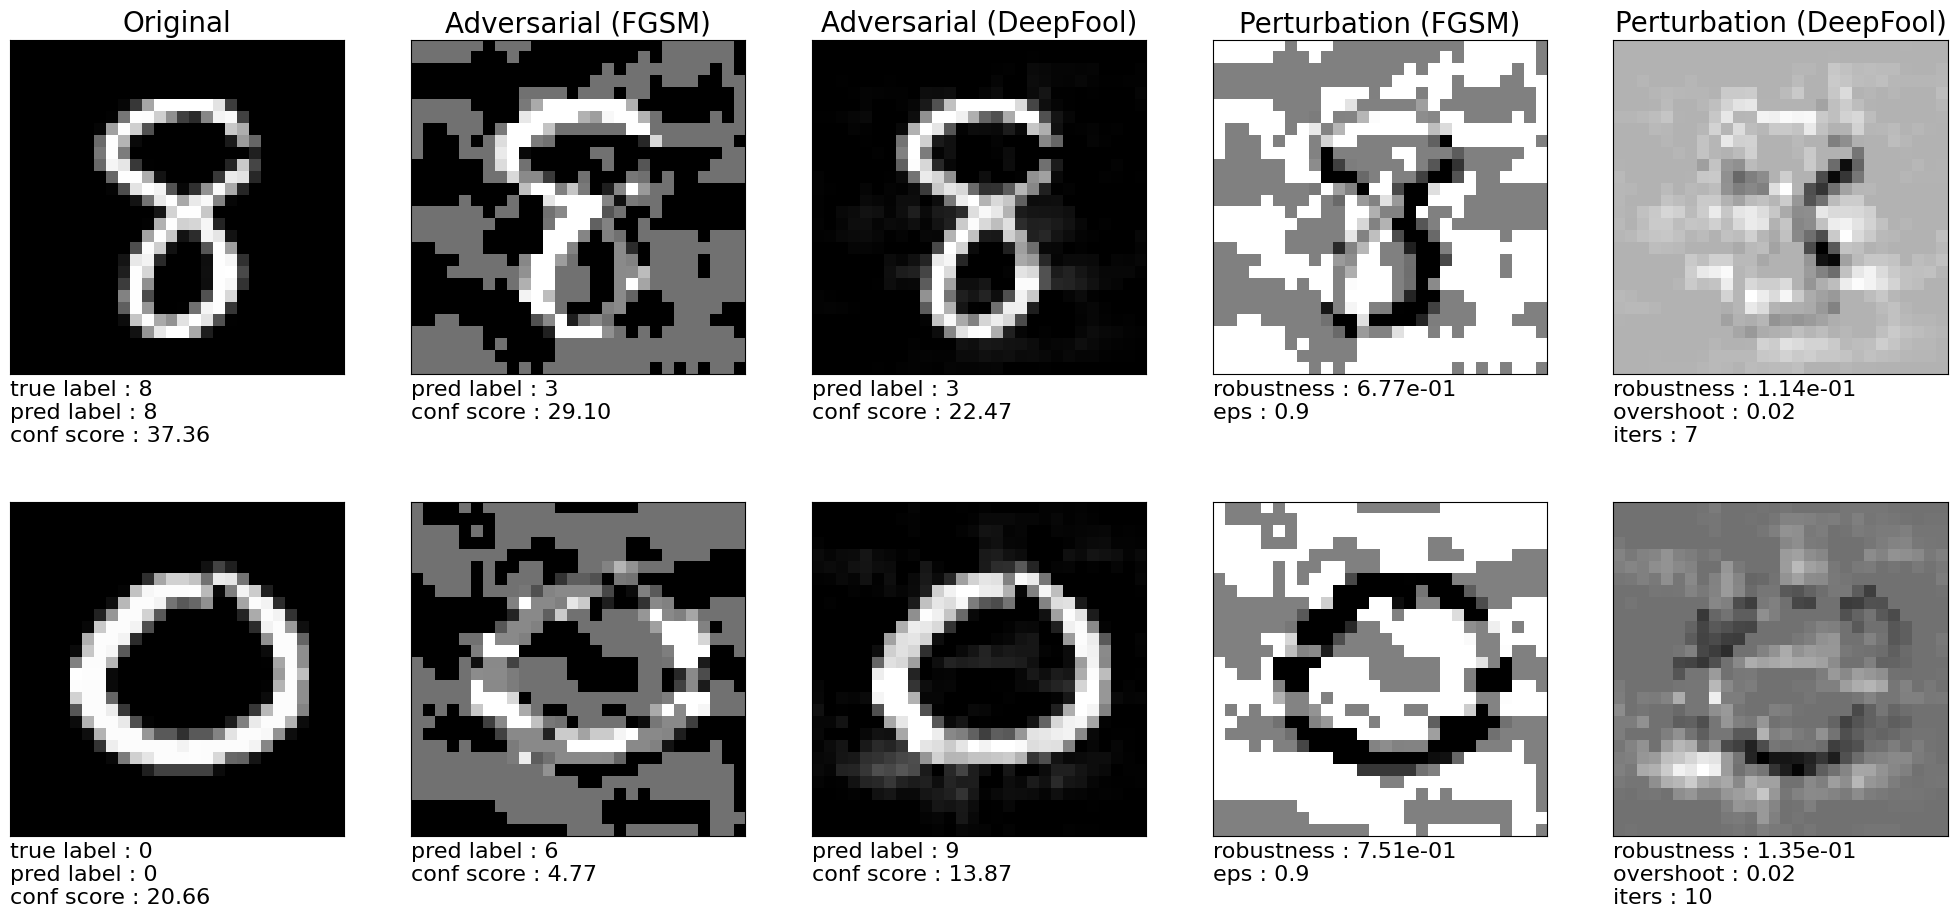

In [24]:
fgsm_eps = 0.9
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_arg, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda': torch.cuda.empty_cache()

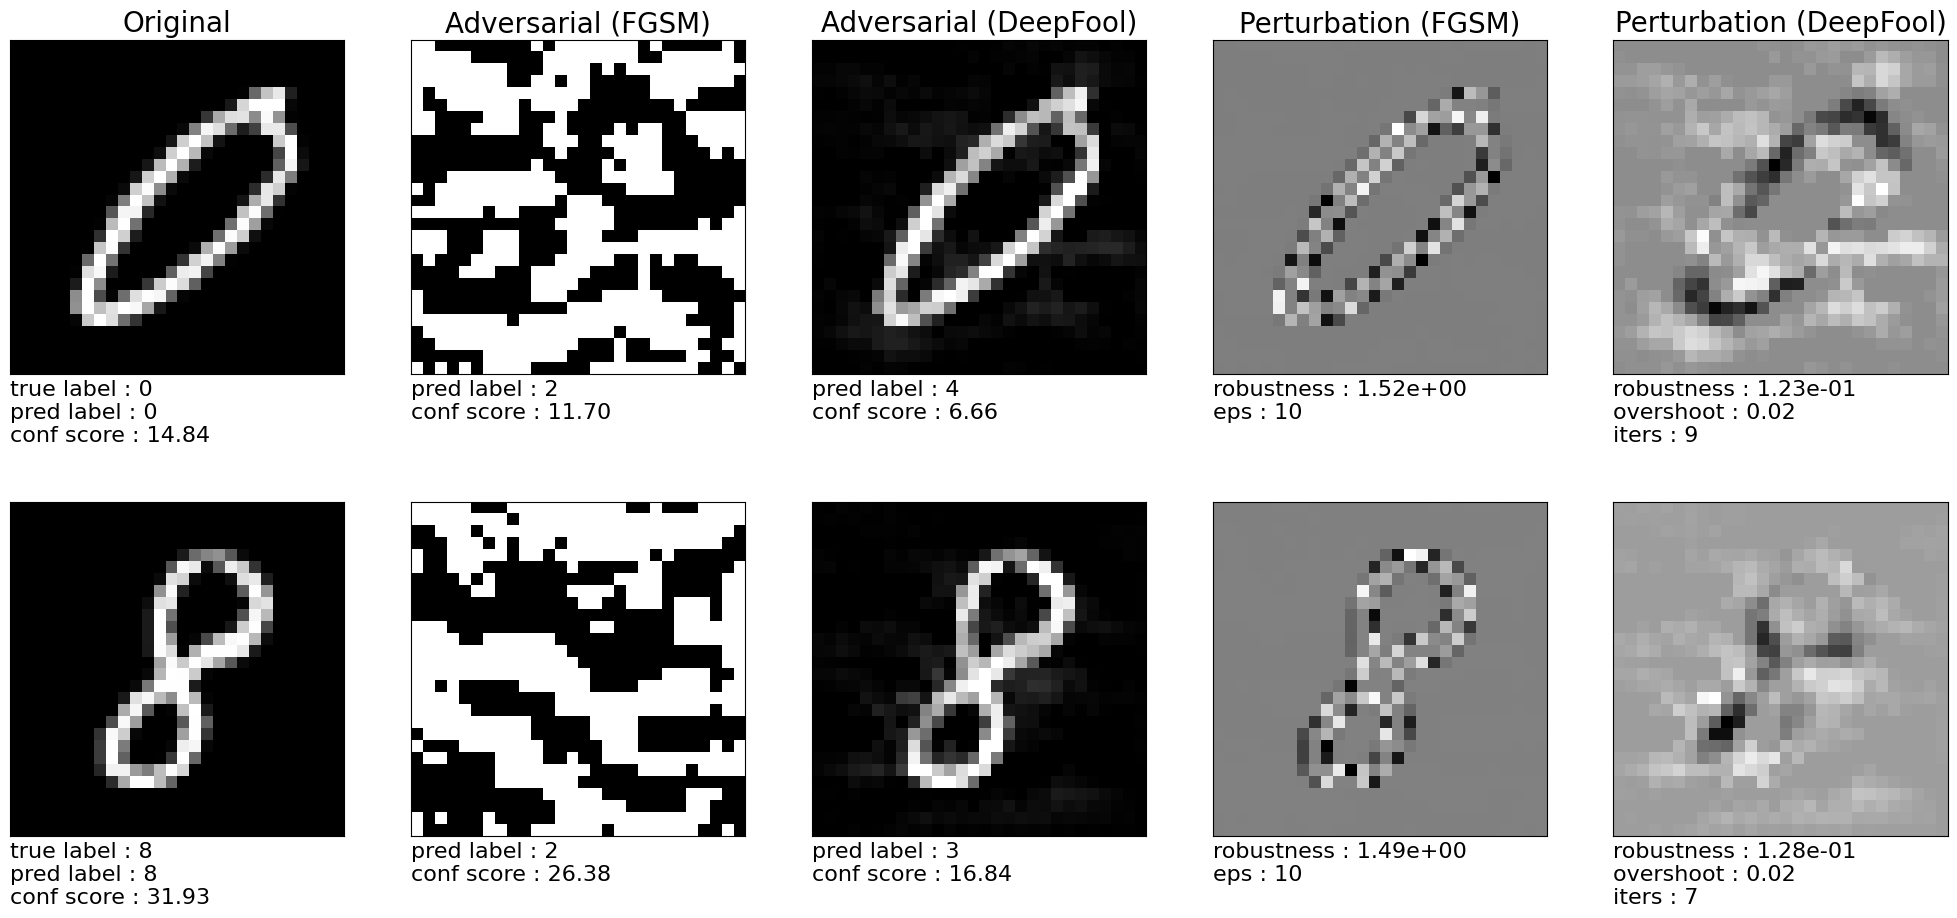

In [25]:
fgsm_eps = 10
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_arg, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda': torch.cuda.empty_cache()

Оценка NiN на CIFAR-10

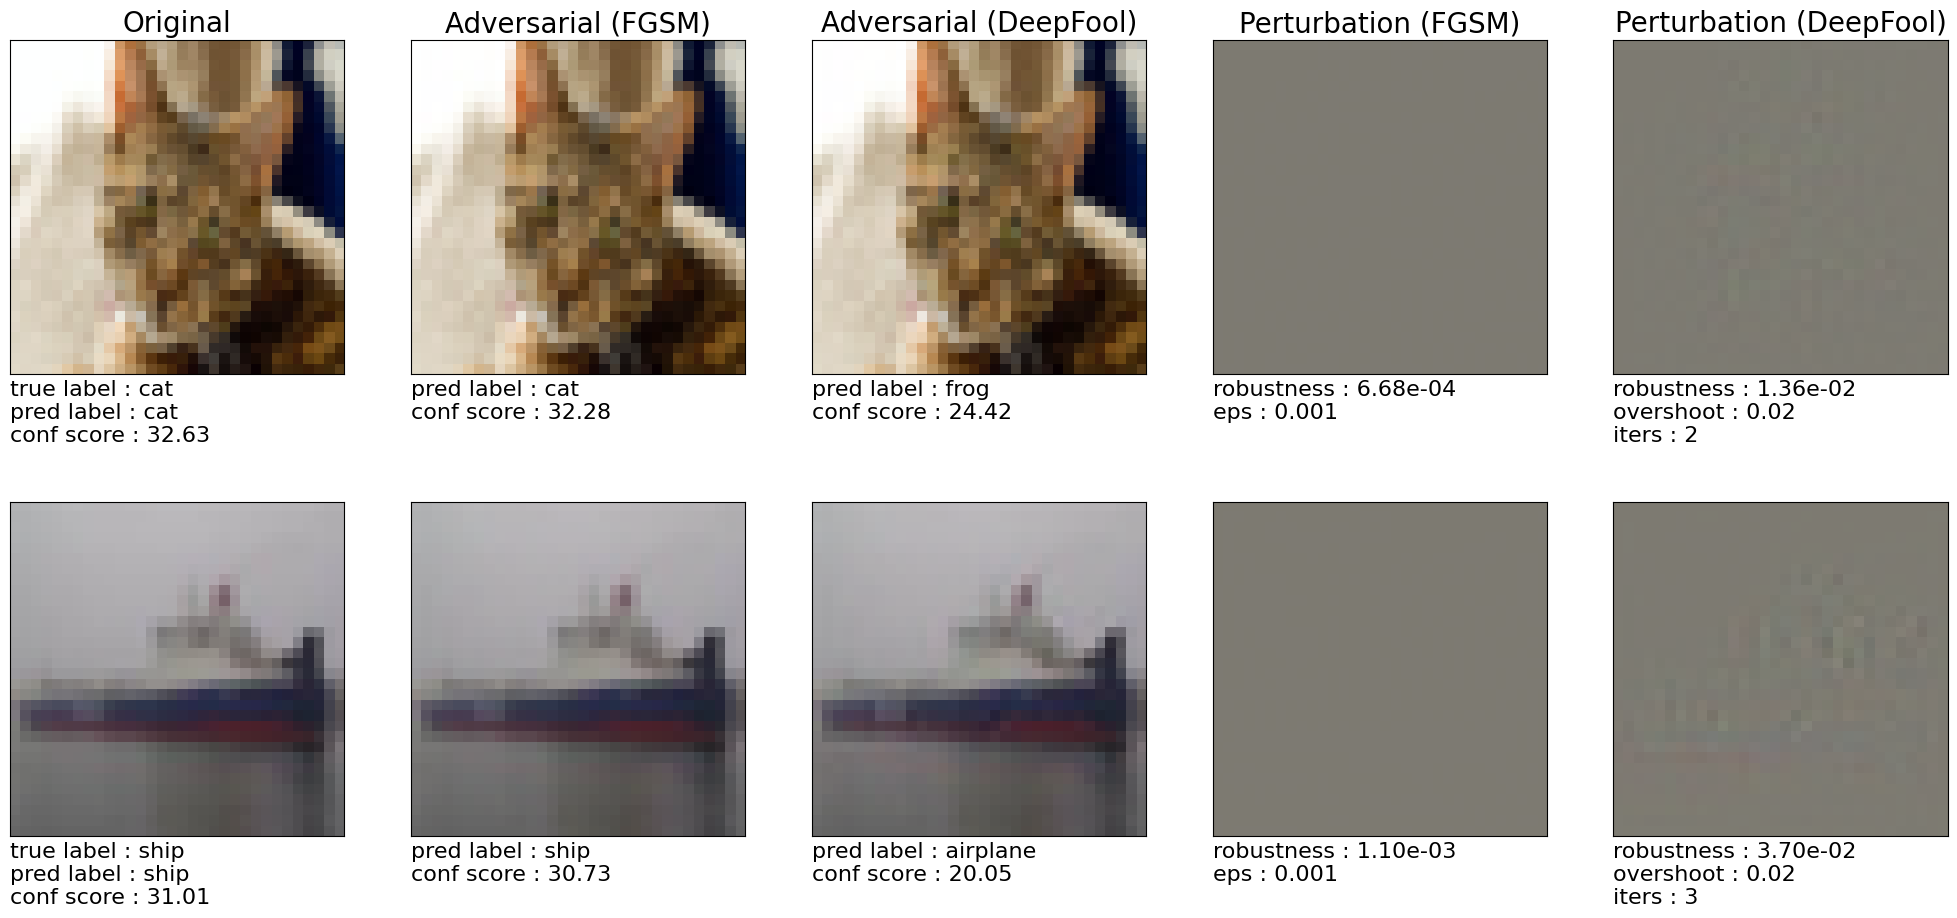

In [13]:
fgsm_eps = 0.001
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_arg, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)

if device.type == 'cuda': torch.cuda.empty_cache()

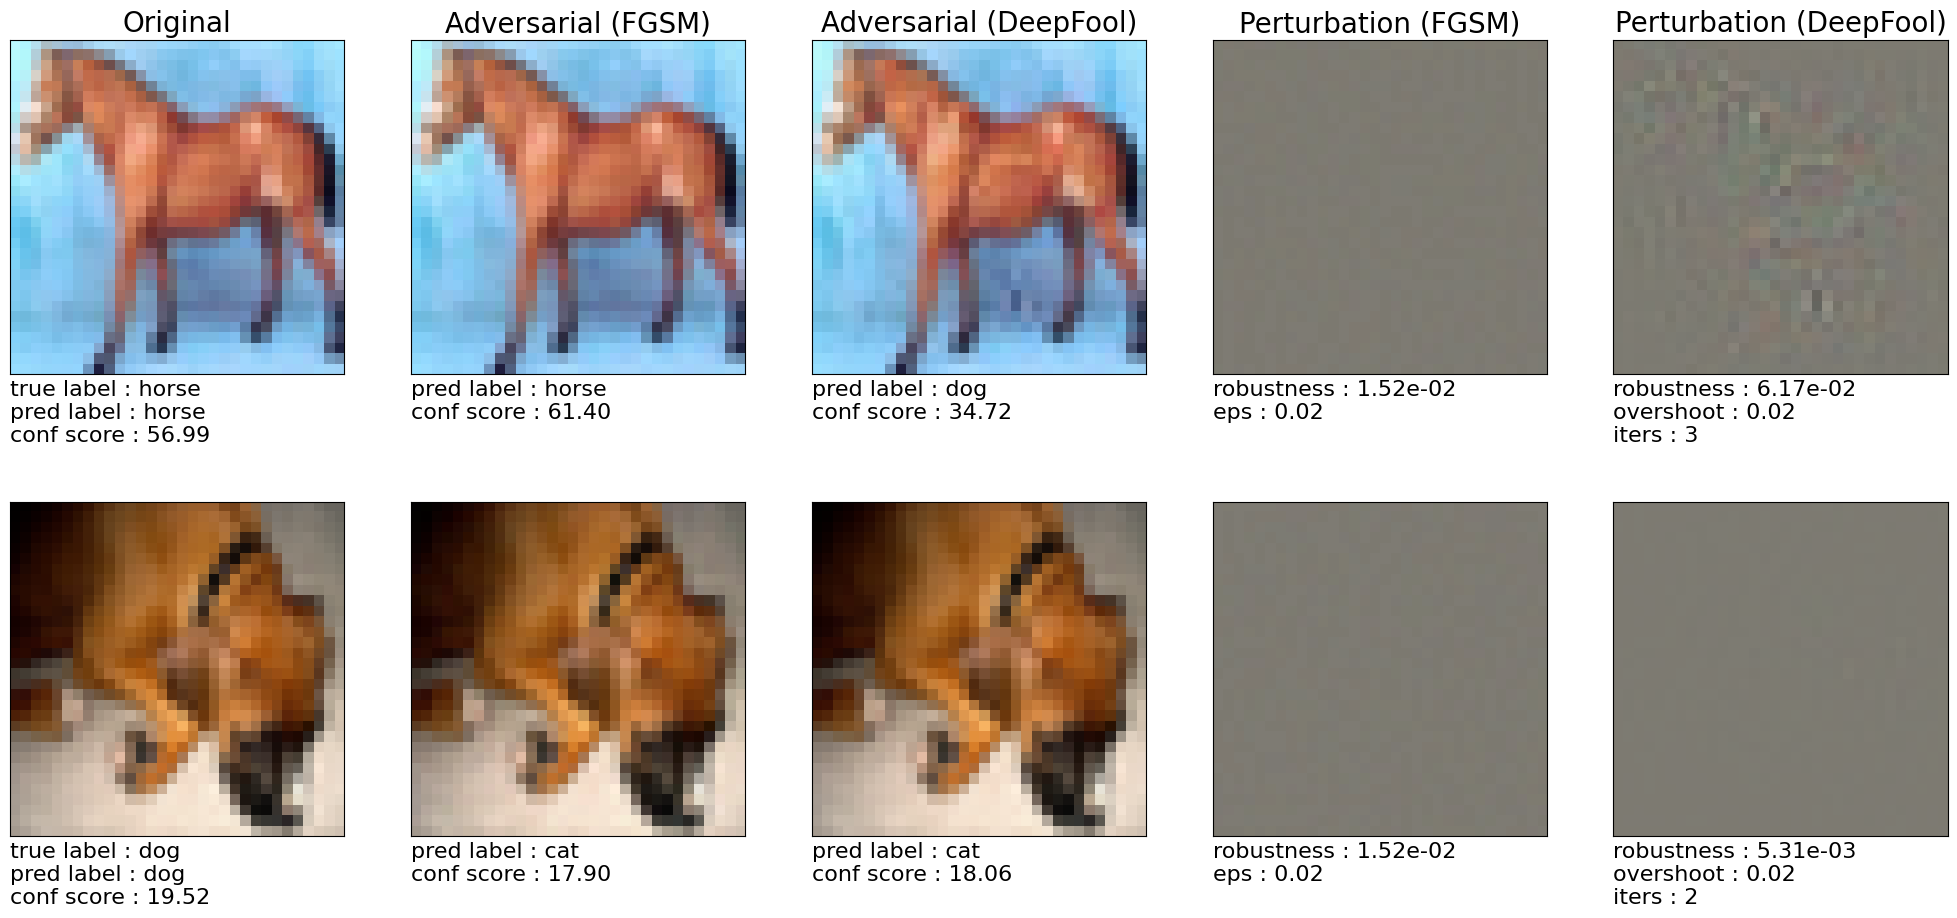

In [14]:
fgsm_eps = 0.02
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_arg, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)

if device.type == 'cuda': torch.cuda.empty_cache()

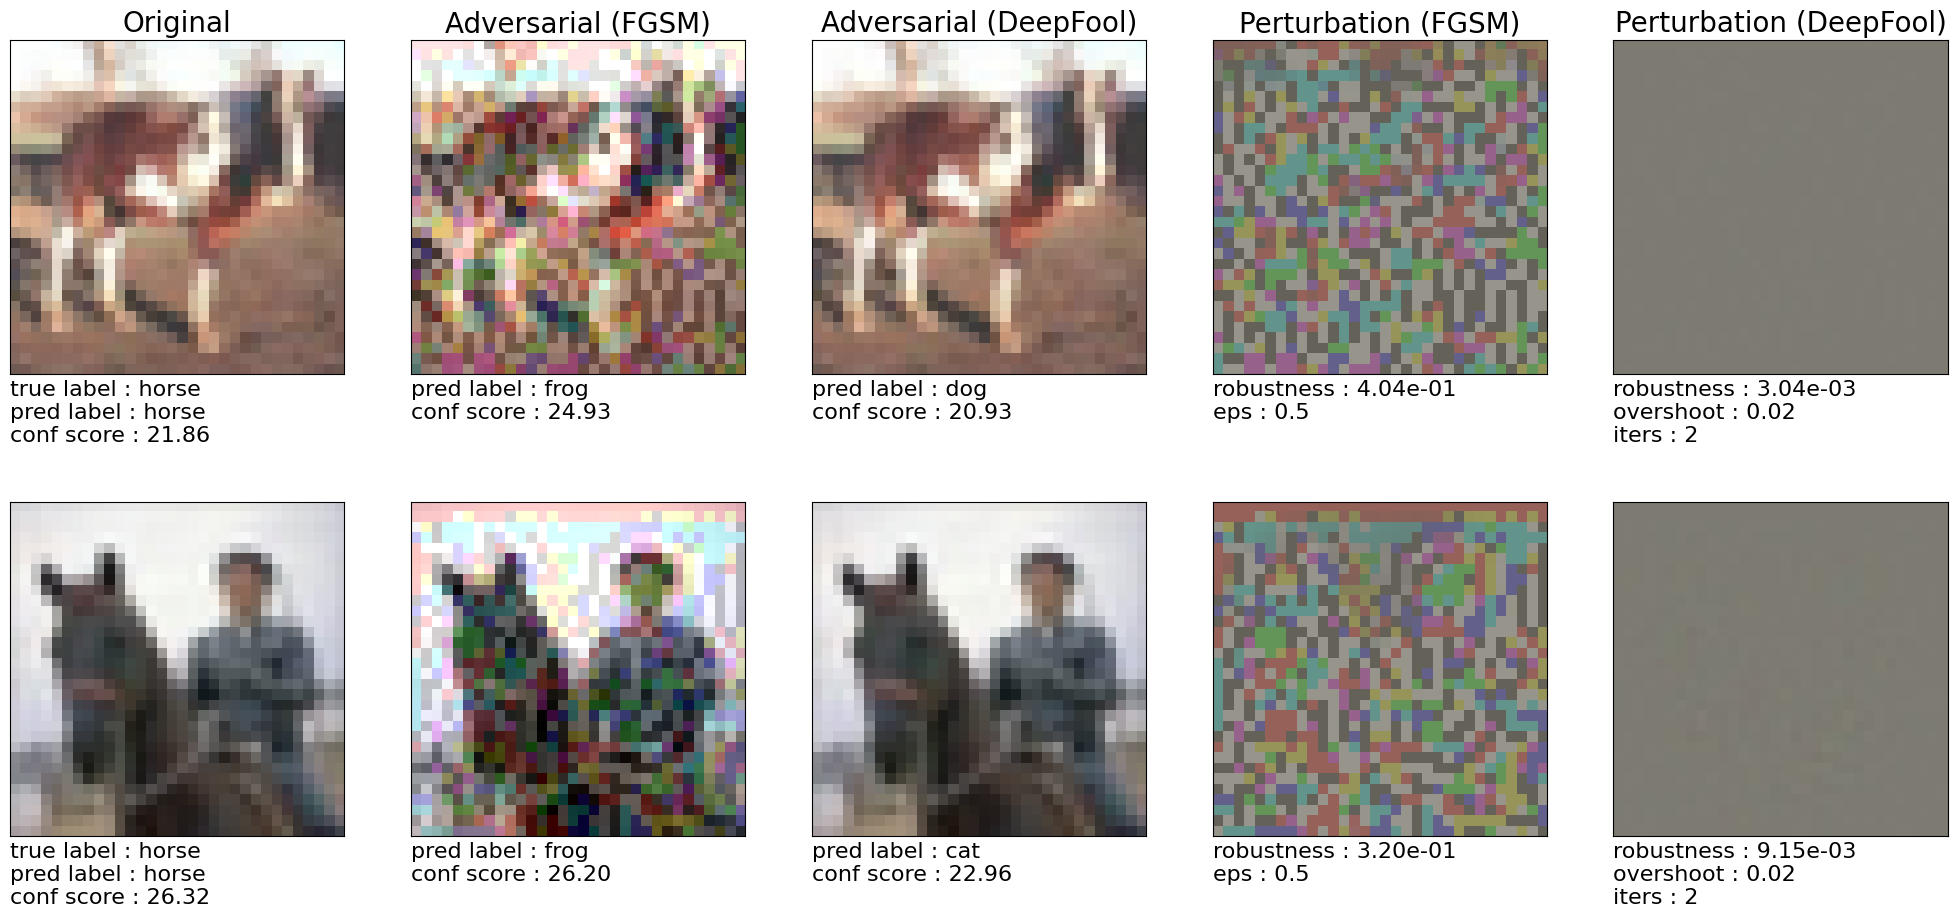

In [15]:
fgsm_eps = 0.5
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_arg, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)

if device.type == 'cuda': torch.cuda.empty_cache()

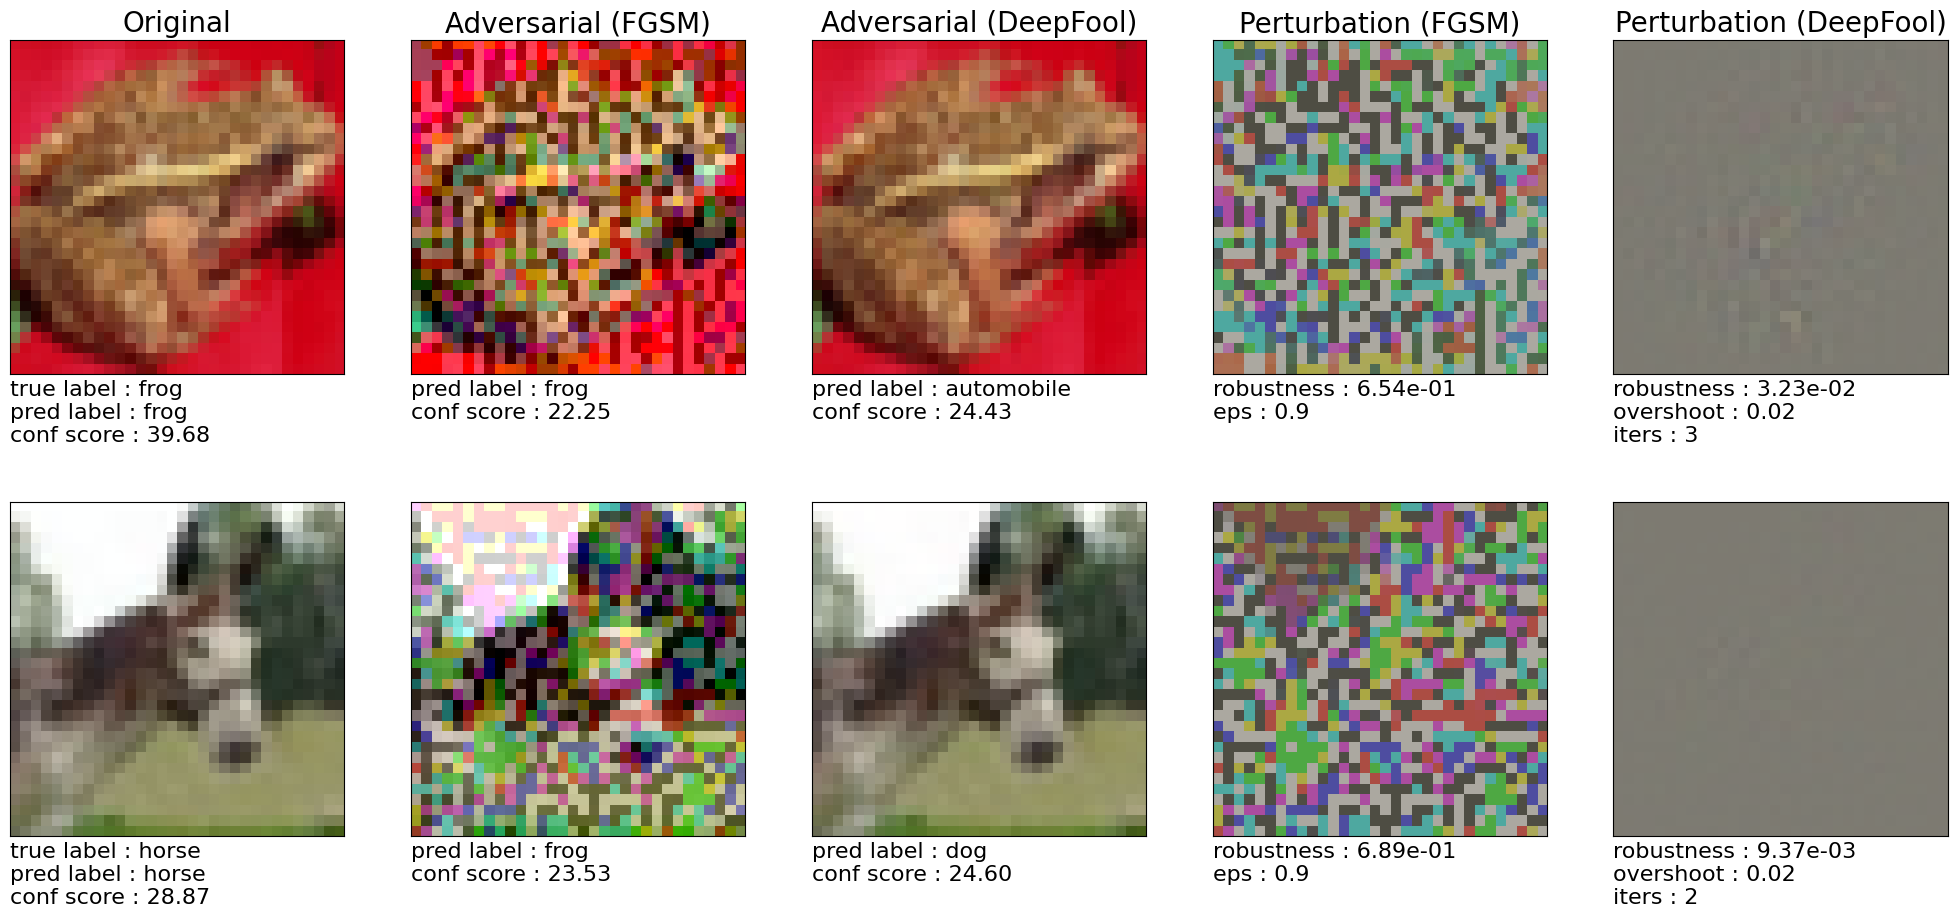

In [16]:
fgsm_eps = 0.9
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_arg, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)

if device.type == 'cuda': torch.cuda.empty_cache()

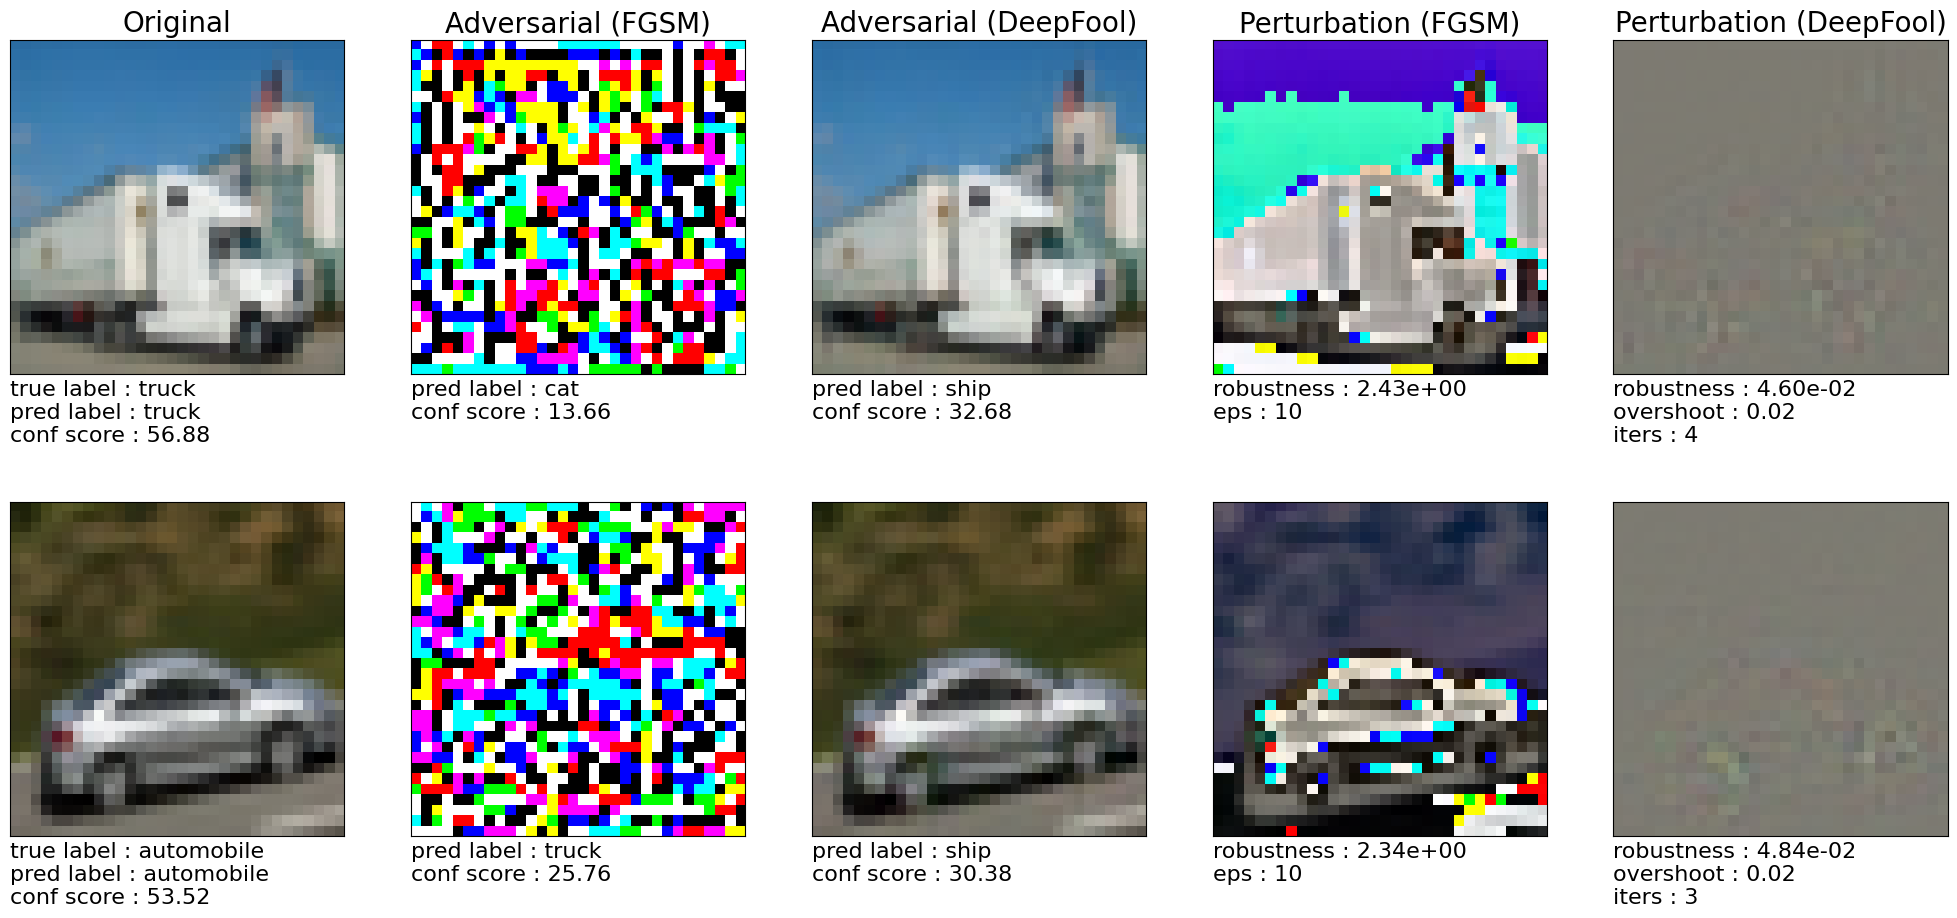

In [17]:
fgsm_eps = 10
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_arg, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)

if device.type == 'cuda': torch.cuda.empty_cache()

Оценка LeNet на датасет CIFAR-10

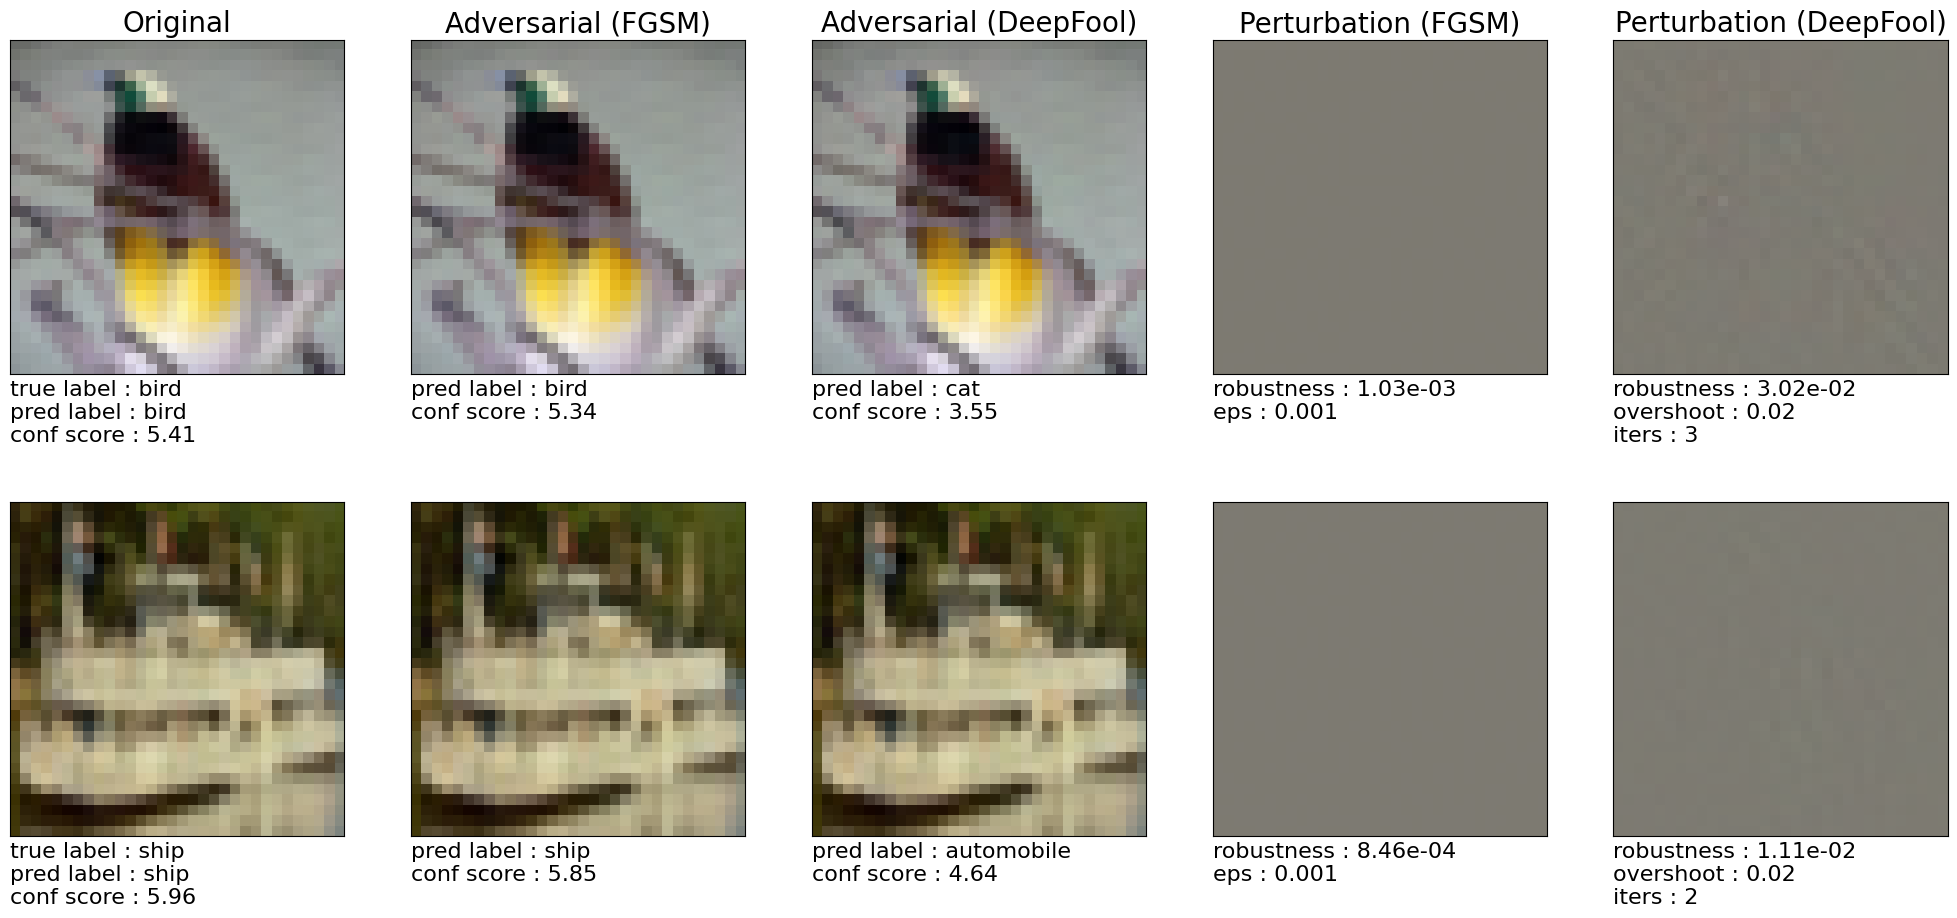

In [18]:
fgsm_eps = 0.001
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_arg, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)

if device.type == 'cuda': torch.cuda.empty_cache()

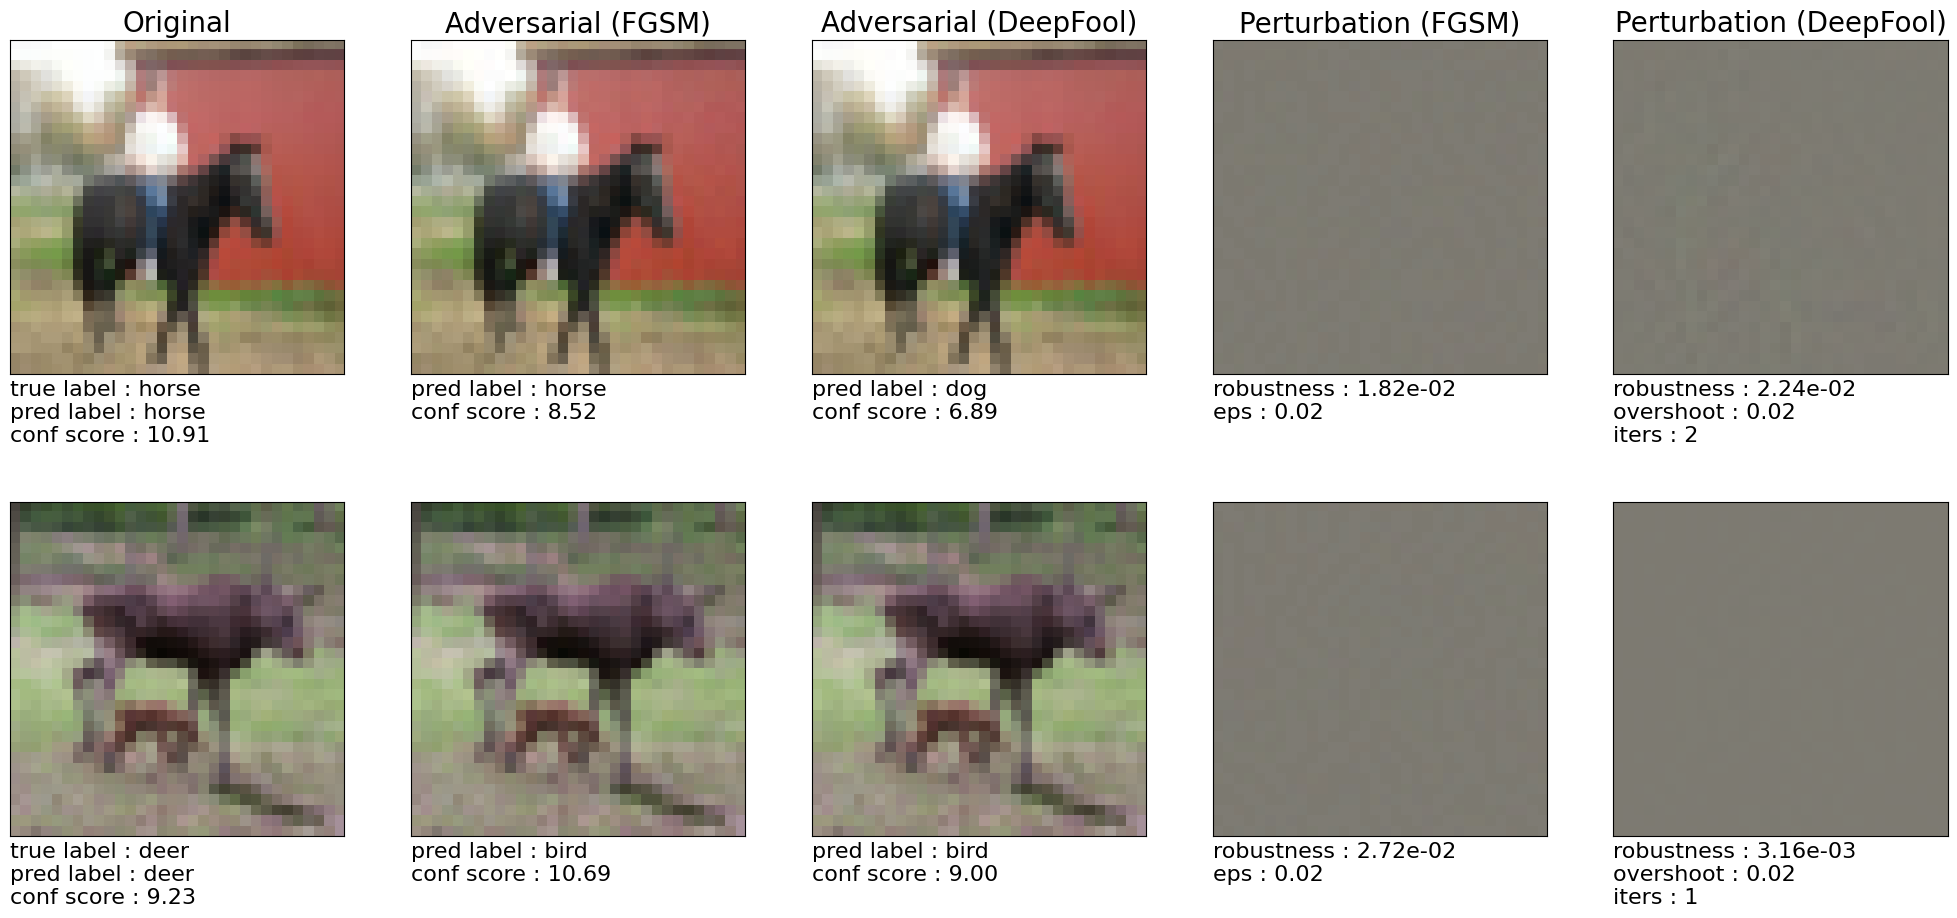

In [19]:
fgsm_eps = 0.02
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_arg, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)

if device.type == 'cuda': torch.cuda.empty_cache()

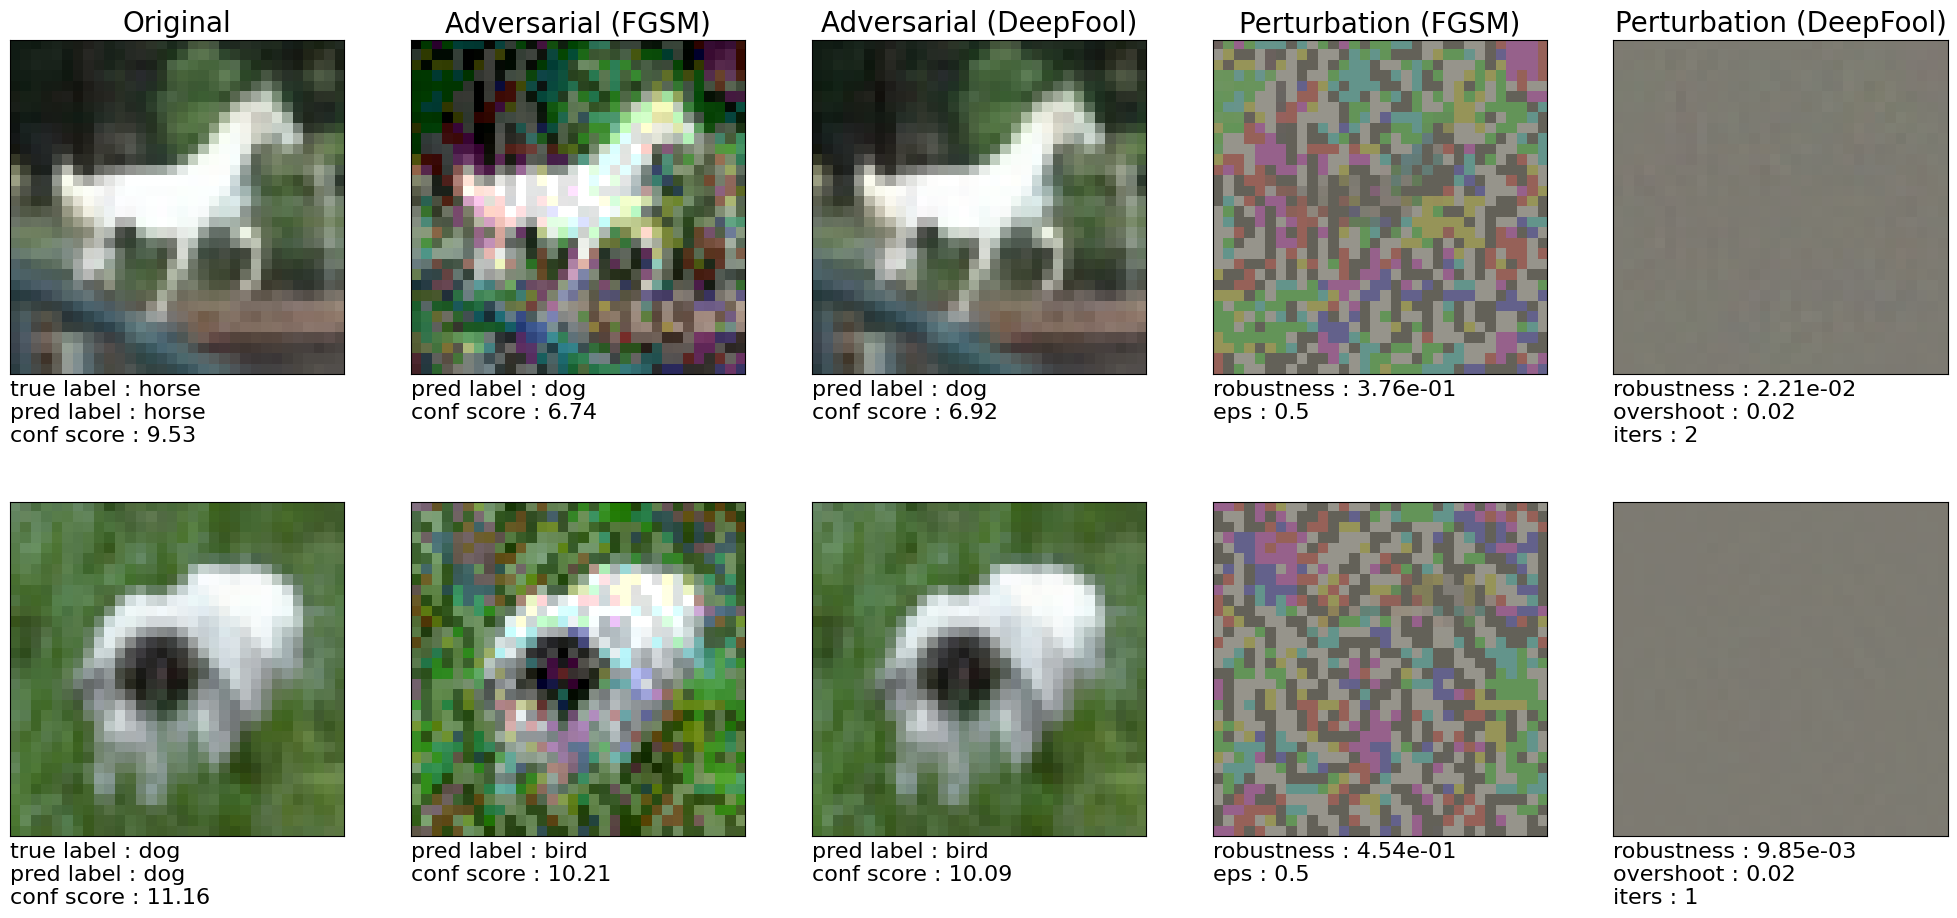

In [20]:
fgsm_eps = 0.5
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_arg, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)

if device.type == 'cuda': torch.cuda.empty_cache()

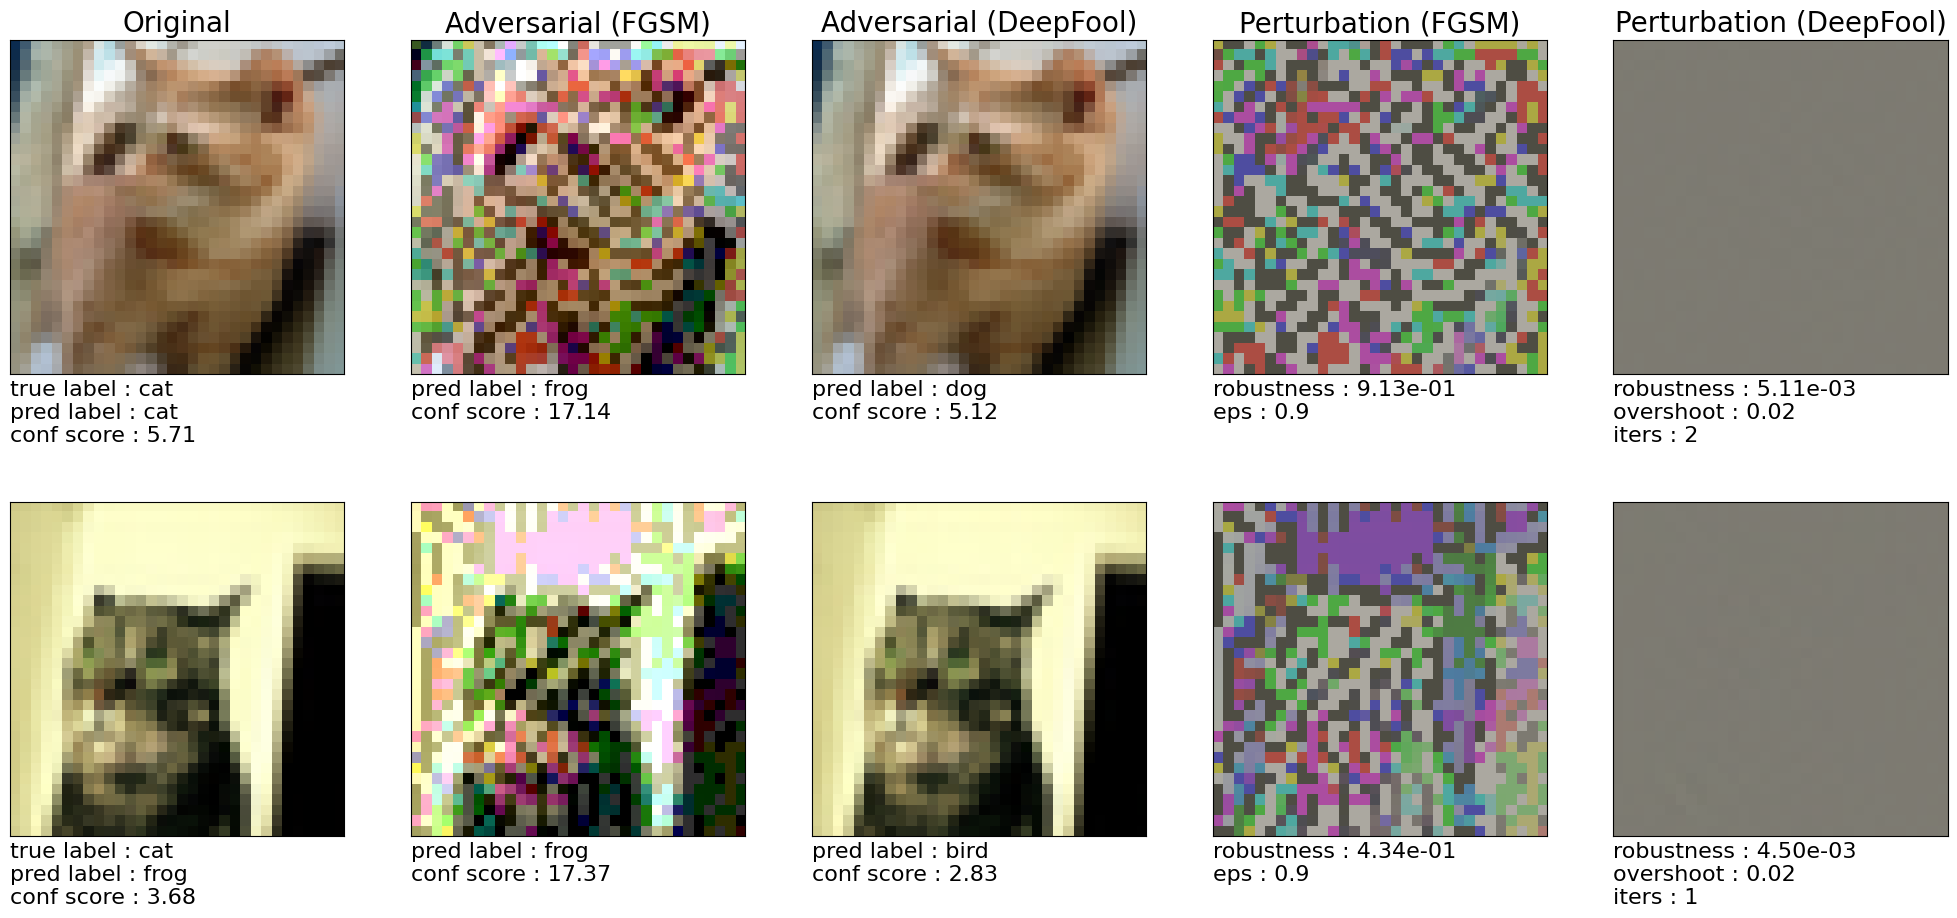

In [21]:
fgsm_eps = 0.9
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_arg, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)

if device.type == 'cuda': torch.cuda.empty_cache()

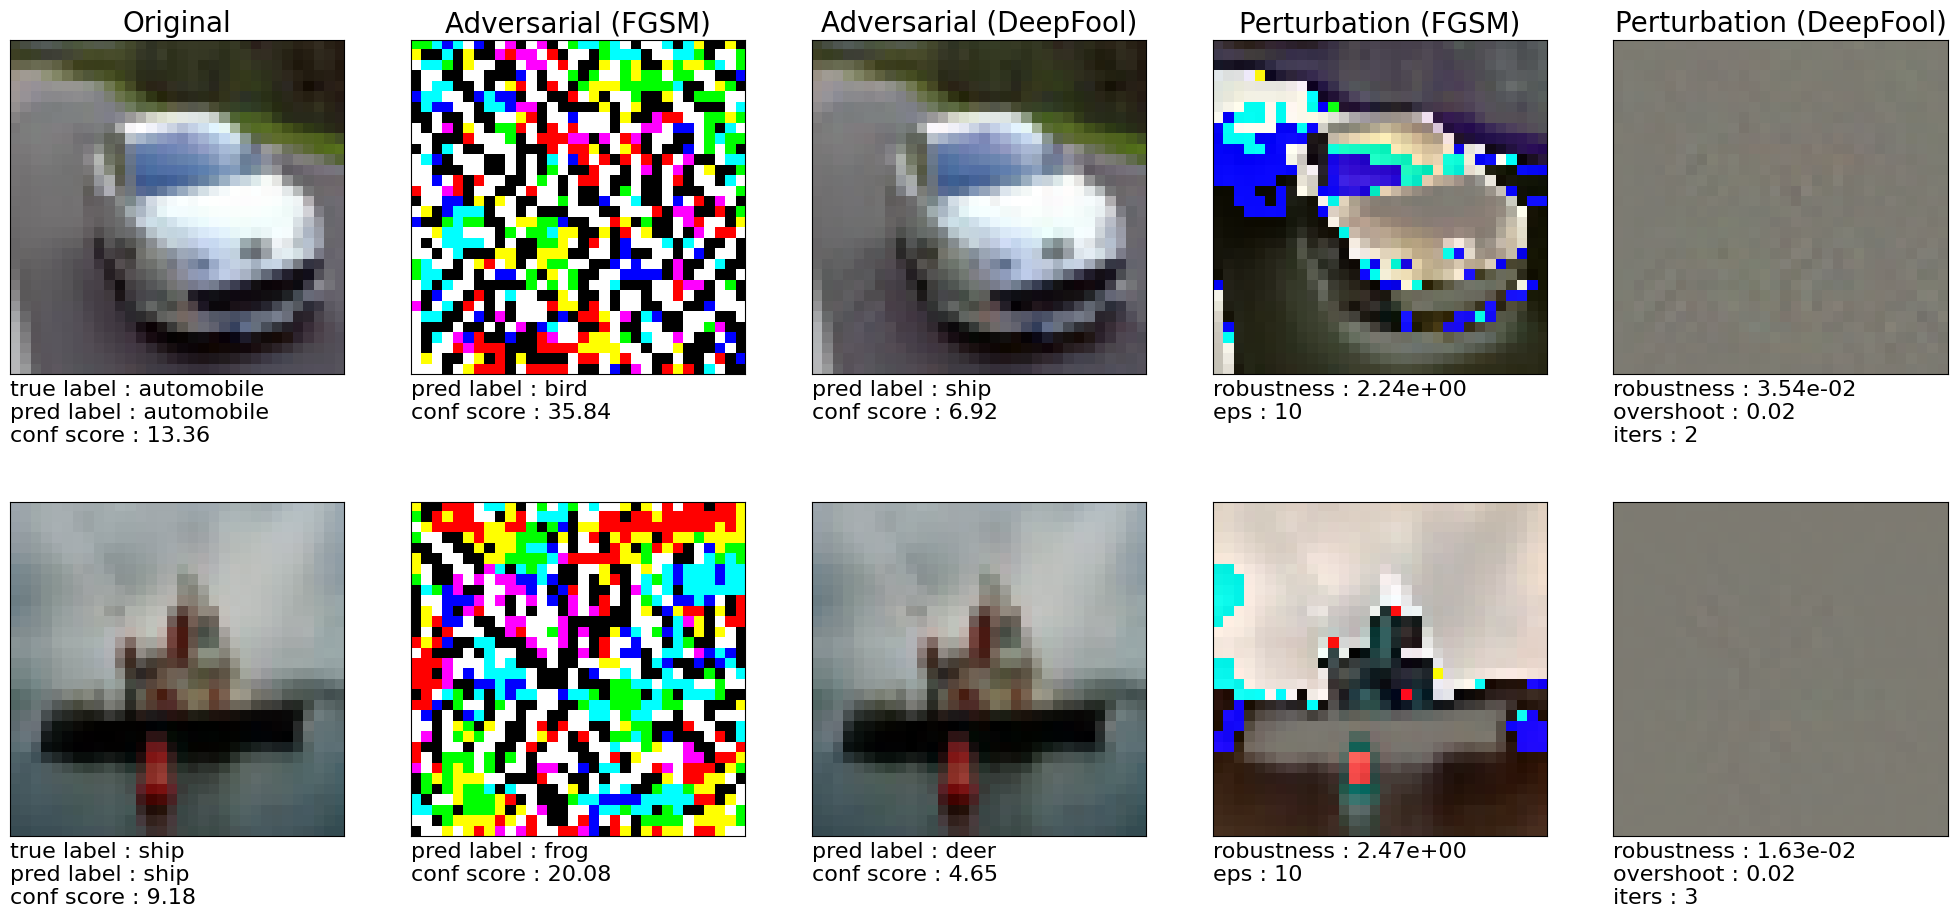

In [22]:
fgsm_eps = 10
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_arg, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)

if device.type == 'cuda': torch.cuda.empty_cache()